# **Fake News Detection on UPFD dataset**

# Setup


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install torch geometric
import os
if 'IS_GRADESCOPE_ENV' not in os.environ:
  !pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
  !pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
  !pip install torch-geometric
  !pip install -q git+https://github.com/snap-stanford/deepsnap.git

import torch_geometric
torch_geometric.__version__

Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl size=504020 sha256=9befd618a566de7cc6b7cf1ecaf3f9d8eeb6ffd1b40f81e83aadce3362c7eba9
  Stored in directory: /root/.cache/pip/wheels/92/f1/2b/3b46d54b134259f58c8363568569053248040859b1a145b3ce
Successfully built torch-scatter
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp310-cp310-linux_x86_64.whl size=1071448 sha256=ab99baf01ec23df0844eac6b8669bca289056c42d13345ff4a3aa3df50ce693b
  Stored in directory: /root/.cache/pip/wheels/c9/dd/0f/a6a16f9f3b0236733d257b4b4ea91b548b984a341ed3b8f38c
S

'2.5.1'

In [ ]:
import argparse
import os.path as osp
import numpy as np
from math import ceil
import pandas as pd
import copy
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.nn import Linear

from torch_geometric.datasets import UPFD
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, GCNConv, SAGEConv, global_max_pool, DenseSAGEConv
from torch_geometric.transforms import ToUndirected
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from torch_geometric.nn import global_mean_pool as gmp

import torch.nn.functional as F
from torch_geometric.data import DenseDataLoader
import torch_geometric.transforms as T
from torch_geometric.nn import DenseSAGEConv, dense_diff_pool
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import time
from tqdm import tqdm


# Load Data

In [ ]:
import os
import os.path as osp
import torch
from typing import Callable, List, Optional

import numpy as np
import scipy.sparse as sp
import torch

from torch_geometric.data import (
    Data,
    InMemoryDataset,
    download_url,
    extract_zip,
)
from torch_geometric.io import read_txt_array
from torch_geometric.utils import coalesce, cumsum


class UPFD(InMemoryDataset):
    url = 'https://drive.usercontent.google.com/download?id={}&export=download&authuser=5&confirm=t'

    ids = {
        'politifact': '1KOmSrlGcC50PjkvRVbyb_WoWHVql06J-',
        'gossipcop': '10bEhVUnJQqsYI9-D9tmSMDHmjBki8lcX',
    }

    def __init__(
        self,
        root: str,
        name: str,
        feature: str,
        split: str = "train",
        transform: Optional[Callable] = None,
        pre_transform: Optional[Callable] = None,
        pre_filter: Optional[Callable] = None,
    ) -> None:
        self.root = root
        self.name = name
        self.feature = feature
        super().__init__(root, transform, pre_transform, pre_filter)

        assert split in ['train', 'val', 'test']
        path = self.processed_paths[['train', 'val', 'test'].index(split)]
        self.load(path)

    @property
    def raw_dir(self) -> str:
        return osp.join(self.root, self.name, 'raw')

    @property
    def processed_dir(self) -> str:
        return osp.join(self.root, self.name, 'processed', self.feature)

    @property
    def raw_file_names(self) -> List[str]:
        return [
            'node_graph_id.npy', 'graph_labels.npy', 'A.txt', 'train_idx.npy',
            'val_idx.npy', 'test_idx.npy', f'new_{self.feature}_feature.npz'
        ]

    @property
    def processed_file_names(self) -> List[str]:
        return ['train.pt', 'val.pt', 'test.pt']

    def download(self) -> None:
        path = download_url(self.url.format(self.ids[self.name]),self.raw_dir)
        extract_zip(path, self.raw_dir)
        os.remove(path)

    def process(self) -> None:
        x = sp.load_npz(
            osp.join(self.raw_dir, f'new_{self.feature}_feature.npz'))
        x = torch.from_numpy(x.todense()).to(torch.float)

        edge_index = read_txt_array(osp.join(self.raw_dir, 'A.txt'), sep=',',
                                    dtype=torch.long).t()
        edge_index = coalesce(edge_index, num_nodes=x.size(0))

        y = np.load(osp.join(self.raw_dir, 'graph_labels.npy'))
        y = torch.from_numpy(y).to(torch.long)
        _, y = y.unique(sorted=True, return_inverse=True)

        batch = np.load(osp.join(self.raw_dir, 'node_graph_id.npy'))
        batch = torch.from_numpy(batch).to(torch.long)

        node_slice = cumsum(batch.bincount())
        edge_slice = cumsum(batch[edge_index[0]].bincount())
        graph_slice = torch.arange(y.size(0) + 1)
        self.slices = {
            'x': node_slice,
            'edge_index': edge_slice,
            'y': graph_slice
        }

        edge_index -= node_slice[batch[edge_index[0]]].view(1, -1)
        self.data = Data(x=x, edge_index=edge_index, y=y)

        for path, split in zip(self.processed_paths, ['train', 'val', 'test']):
            idx = np.load(osp.join(self.raw_dir, f'{split}_idx.npy')).tolist()
            data_list = [self.get(i) for i in idx]
            if self.pre_filter is not None:
                data_list = [d for d in data_list if self.pre_filter(d)]
            if self.pre_transform is not None:
                data_list = [self.pre_transform(d) for d in data_list]
            self.save(data_list, path)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({len(self)}, name={self.name}, '
                f'feature={self.feature})')

In [ ]:
def load_data(split):
  data_profile =  UPFD('/content/drive/MyDrive', "politifact", "profile", split, ToUndirected())
  data_bert =  UPFD('/content/drive/MyDrive', "politifact", "bert", split, ToUndirected())
  data_profile.data.x = torch.cat((data_profile.data.x, data_bert.data.x),dim =1)

  return data_profile

In [ ]:
# Retrieve data
train_data = load_data('train')
test_data = load_data('test')
val_data = load_data('val')

# Prepare data loader for GNN
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = DataLoader(val_data, batch_size=128, shuffle=False)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

Processing...
Done!
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


# **Bi_GCN**

In [ ]:
!pip install utils

  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13906 sha256=6d29d1913171e77cf18ac6cfd817dca1adc417f5fa1d0126f851e305270fc877
  Stored in directory: /root/.cache/pip/wheels/b8/39/f5/9d0ca31dba85773ececf0a7f5469f18810e1c8a8ed9da28ca7
Successfully built utils


In [ ]:
!pip install keras
!pip install scikit-learn
!pip install tqdm
!pip install numpy
!pip install scipy

In [ ]:
import os
import sys
sys.path.append(os.getcwd())
import argparse
from tqdm import tqdm
import copy as cp

import torch
from torch.utils.data import random_split
from torch_scatter import scatter_mean
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader, DataListLoader
from torch_geometric.nn import DataParallel


import sys
sys.path.append('/content/drive/MyDrive/')
from data_loader import *
from eval_helper import *

In [ ]:
import os
import sys
sys.path.append(os.getcwd())
import argparse
from tqdm import tqdm
import copy as cp

import torch
from torch.utils.data import random_split
from torch_scatter import scatter_mean
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader, DataListLoader
from torch_geometric.nn import DataParallel


class TDrumorGCN(torch.nn.Module):
	def __init__(self, in_feats, hid_feats, out_feats):
		super(TDrumorGCN, self).__init__()
		self.conv1 = GCNConv(in_feats, hid_feats)
		self.conv2 = GCNConv(hid_feats+in_feats, out_feats)

	def forward(self, data):
		x, edge_index = data.x, data.edge_index
		x1 = cp.copy(x.float())
		x = self.conv1(x, edge_index)
		x2 = cp.copy(x)
		rootindex = data.root_index
		root_extend = torch.zeros(len(data.batch), x1.size(1)).to(rootindex.device)
		batch_size = max(data.batch) + 1

		for num_batch in range(batch_size):
			index = (torch.eq(data.batch, num_batch))
			root_extend[index] = x1[rootindex[num_batch]]
		x = torch.cat((x, root_extend), 1)

		x = F.relu(x)
		x = F.dropout(x, training=self.training)
		x = self.conv2(x, edge_index)
		x = F.relu(x)
		root_extend = torch.zeros(len(data.batch), x2.size(1)).to(rootindex.device)
		for num_batch in range(batch_size):
			index = (torch.eq(data.batch, num_batch))
			root_extend[index] = x2[rootindex[num_batch]]
		x = torch.cat((x, root_extend), 1)
		x = scatter_mean(x, data.batch, dim=0)

		return x


class BUrumorGCN(torch.nn.Module):
	def __init__(self, in_feats, hid_feats, out_feats):
		super(BUrumorGCN, self).__init__()
		self.conv1 = GCNConv(in_feats, hid_feats)
		self.conv2 = GCNConv(hid_feats+in_feats, out_feats)

	def forward(self, data):
		x, edge_index = data.x, data.BU_edge_index
		x1 = cp.copy(x.float())
		x = self.conv1(x, edge_index)
		x2 = cp.copy(x)

		rootindex = data.root_index
		root_extend = torch.zeros(len(data.batch), x1.size(1)).to(rootindex.device)
		batch_size = max(data.batch) + 1
		for num_batch in range(batch_size):
			index = (torch.eq(data.batch, num_batch))
			root_extend[index] = x1[rootindex[num_batch]]
		x = torch.cat((x, root_extend), 1)

		x = F.relu(x)
		x = F.dropout(x, training=self.training)
		x = self.conv2(x, edge_index)
		x = F.relu(x)
		root_extend = torch.zeros(len(data.batch), x2.size(1)).to(rootindex.device)
		for num_batch in range(batch_size):
			index = (torch.eq(data.batch, num_batch))
			root_extend[index] = x2[rootindex[num_batch]]
		x = torch.cat((x, root_extend), 1)

		x = scatter_mean(x, data.batch, dim=0)
		return x


class Net(torch.nn.Module):
	def __init__(self, in_feats, hid_feats, out_feats):
		super(Net, self).__init__()
		self.TDrumorGCN = TDrumorGCN(in_feats, hid_feats, out_feats)
		self.BUrumorGCN = BUrumorGCN(in_feats, hid_feats, out_feats)
		self.fc = torch.nn.Linear((out_feats+hid_feats) * 2, 2)

	def forward(self, data):
		TD_x = self.TDrumorGCN(data)
		BU_x = self.BUrumorGCN(data)
		x = torch.cat((TD_x, BU_x), 1)
		x = self.fc(x)
		x = F.log_softmax(x, dim=1)
		return x


def compute_test(loader, verbose=False):
	model.eval()
	loss_test = 0.0
	out_log = []
	with torch.no_grad():
		for data in loader:
			if not args.multi_gpu:
				data = data.to(args.device)
			out = model(data)
			if args.multi_gpu:
				y = torch.cat([d.y for d in data]).to(out.device)
			else:
				y = data.y
			if verbose:
				print(F.softmax(out, dim=1).cpu().numpy())
			out_log.append([F.softmax(out, dim=1), y])
			loss_test += F.nll_loss(out, y).item()
	return eval_deep(out_log, loader), loss_test

## **Bi_GCN Model Performance**

In [ ]:
parser = argparse.ArgumentParser()

parser.add_argument('--seed', type=int, default=777, help='random seed')
parser.add_argument('--device', type=str, default='cpu', help='specify cuda devices')
# hyper-parameters
parser.add_argument('--dataset', type=str, default='politifact', help='[politifact, gossipcop]')
parser.add_argument('--batch_size', type=int, default=128, help='batch size')
parser.add_argument('--lr', type=float, default=0.001, help='learning rate')
parser.add_argument('--weight_decay', type=float, default=0.001, help='weight decay')
parser.add_argument('--nhid', type=int, default=128, help='hidden size')
parser.add_argument('--TDdroprate', type=float, default=0.2, help='dropout ratio')
parser.add_argument('--BUdroprate', type=float, default=0.2, help='dropout ratio')
parser.add_argument('--epochs', type=int, default=50, help='maximum number of epochs')
parser.add_argument('--multi_gpu', type=bool, default=False, help='multi-gpu mode')
parser.add_argument('--feature', type=str, default='bert', help='feature type, [profile, spacy, bert, content]')

# args = parser.parse_args()
args, _ = parser.parse_known_args()
torch.manual_seed(args.seed)
if torch.cuda.is_available():
	torch.cuda.manual_seed(args.seed)

dataset = FNNDataset(root='/content/drive/MyDrive', feature=args.feature, empty=False, name=args.dataset,
					 transform=DropEdge(args.TDdroprate, args.BUdroprate))

args.num_classes = dataset.num_classes
args.num_features = dataset.num_features


num_training = int(len(dataset) * 0.2)
num_val = int(len(dataset) * 0.1)
num_test = len(dataset) - (num_training + num_val)
training_set, validation_set, test_set = random_split(dataset, [num_training, num_val, num_test])

if args.multi_gpu:
	loader = DataListLoader
else:
	loader = DataLoader

train_loader = loader(training_set, batch_size=args.batch_size, shuffle=True)
val_loader = loader(validation_set, batch_size=args.batch_size, shuffle=False)
test_loader = loader(test_set, batch_size=args.batch_size, shuffle=False)

model = Net(args.num_features, args.nhid, args.nhid)
if args.multi_gpu:
	model = DataParallel(model)
model = model.to(args.device)

if not args.multi_gpu:
	BU_params = list(map(id, model.BUrumorGCN.conv1.parameters()))
	BU_params += list(map(id, model.BUrumorGCN.conv2.parameters()))
	base_params = filter(lambda p: id(p) not in BU_params, model.parameters())
	optimizer = torch.optim.Adam([
		{'params': base_params},
		{'params': model.BUrumorGCN.conv1.parameters(), 'lr': args.lr / 5},
		{'params': model.BUrumorGCN.conv2.parameters(), 'lr': args.lr / 5}
	], lr=args.lr, weight_decay=args.weight_decay)
else:
	BU_params = list(map(id, model.module.BUrumorGCN.conv1.parameters()))
	BU_params += list(map(id, model.module.BUrumorGCN.conv2.parameters()))
	base_params = filter(lambda p: id(p) not in BU_params, model.parameters())
	optimizer = torch.optim.Adam([
		{'params': base_params},
		{'params': model.module.BUrumorGCN.conv1.parameters(), 'lr': args.lr / 5},
		{'params': model.module.BUrumorGCN.conv2.parameters(), 'lr': args.lr / 5}
	], lr=args.lr, weight_decay=args.weight_decay)



Processing...
Done!
/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## **Bi_GCN Run Model**

In [ ]:
if __name__ == "__main__":

	model.train()
	for epoch in tqdm(range(args.epochs)):
		out_log = []
		loss_train = 0.0
		for i, data in enumerate(train_loader):
			optimizer.zero_grad()
			if not args.multi_gpu:
				data = data.to(args.device)
			out = model(data)
			if args.multi_gpu:
				y = torch.cat([d.y for d in data]).to(out.device)
			else:
				y = data.y
			loss = F.nll_loss(out, y)
			loss.backward()
			optimizer.step()
			loss_train += loss.item()
			out_log.append([F.softmax(out, dim=1), y])
		acc_train, _, _, _, recall_train, auc_train, _ = eval_deep(out_log, train_loader)
		[acc_val, _, _, _, recall_val, auc_val, _], loss_val = compute_test(val_loader)
		print(f'loss_train: {loss_train:.4f}, acc_train: {acc_train:.4f},'
			  f' recall_train: {recall_train:.4f}, auc_train: {auc_train:.4f},'
			  f' loss_val: {loss_val:.4f}, acc_val: {acc_val:.4f},'
			  f' recall_val: {recall_val:.4f}, auc_val: {auc_val:.4f}')

	[acc, f1_macro, f1_micro, precision, recall, auc, ap], test_loss = compute_test(test_loader, verbose=False)
	print(f'Test set results: acc: {acc:.4f}, f1_macro: {f1_macro:.4f}, f1_micro: {f1_micro:.4f},'
		  f'precision: {precision:.4f}, recall: {recall:.4f}, auc: {auc:.4f}, ap: {ap:.4f}')
acc_BiGCN = acc
f1_BiGCN = f1_macro
auc_BiGCN = auc

  2%|▏         | 1/50 [00:02<02:22,  2.92s/it]

loss_train: 0.7047, acc_train: 0.5161, recall_train: 0.5000, auc_train: 0.4915, loss_val: 1.3378, acc_val: 0.4194, recall_val: 0.0000, auc_val: 0.3889


  4%|▍         | 2/50 [00:04<01:44,  2.17s/it]

loss_train: 0.9370, acc_train: 0.5806, recall_train: 0.0000, auc_train: 0.5032, loss_val: 0.8809, acc_val: 0.4194, recall_val: 0.0000, auc_val: 0.4530


  6%|▌         | 3/50 [00:06<01:35,  2.03s/it]

loss_train: 0.6984, acc_train: 0.5806, recall_train: 0.0000, auc_train: 0.6635, loss_val: 0.6645, acc_val: 0.5806, recall_val: 0.8333, auc_val: 0.6026


  8%|▊         | 4/50 [00:11<02:31,  3.30s/it]

loss_train: 0.6862, acc_train: 0.5323, recall_train: 0.8846, auc_train: 0.6859, loss_val: 0.6802, acc_val: 0.6129, recall_val: 0.9444, auc_val: 0.6325


 10%|█         | 5/50 [00:15<02:29,  3.31s/it]

loss_train: 0.7555, acc_train: 0.4516, recall_train: 1.0000, auc_train: 0.6880, loss_val: 0.6571, acc_val: 0.5806, recall_val: 0.8333, auc_val: 0.6239


 12%|█▏        | 6/50 [00:18<02:23,  3.25s/it]

loss_train: 0.6725, acc_train: 0.5968, recall_train: 1.0000, auc_train: 0.7585, loss_val: 0.6876, acc_val: 0.5806, recall_val: 0.3333, auc_val: 0.6410


 14%|█▍        | 7/50 [00:22<02:32,  3.54s/it]

loss_train: 0.5983, acc_train: 0.6935, recall_train: 0.3077, auc_train: 0.9177, loss_val: 0.8242, acc_val: 0.4194, recall_val: 0.0000, auc_val: 0.6966


 16%|█▌        | 8/50 [00:26<02:40,  3.83s/it]

loss_train: 0.6211, acc_train: 0.5806, recall_train: 0.0000, auc_train: 0.9306, loss_val: 0.9032, acc_val: 0.4194, recall_val: 0.0000, auc_val: 0.6154


 18%|█▊        | 9/50 [00:30<02:40,  3.91s/it]

loss_train: 0.6420, acc_train: 0.5806, recall_train: 0.0000, auc_train: 0.9038, loss_val: 0.8374, acc_val: 0.4194, recall_val: 0.0000, auc_val: 0.7350


 20%|██        | 10/50 [00:34<02:32,  3.80s/it]

loss_train: 0.6035, acc_train: 0.5806, recall_train: 0.0000, auc_train: 0.9487, loss_val: 0.7109, acc_val: 0.4194, recall_val: 0.0000, auc_val: 0.7692


 22%|██▏       | 11/50 [00:38<02:36,  4.01s/it]

loss_train: 0.5486, acc_train: 0.6613, recall_train: 0.1923, auc_train: 0.9818, loss_val: 0.6313, acc_val: 0.6774, recall_val: 0.7222, auc_val: 0.7179


 24%|██▍       | 12/50 [00:42<02:32,  4.02s/it]

loss_train: 0.5321, acc_train: 0.8710, recall_train: 0.9231, auc_train: 0.9669, loss_val: 0.6182, acc_val: 0.6774, recall_val: 0.8889, auc_val: 0.6752


 26%|██▌       | 13/50 [00:47<02:32,  4.12s/it]

loss_train: 0.5443, acc_train: 0.7742, recall_train: 1.0000, auc_train: 0.9434, loss_val: 0.6085, acc_val: 0.6774, recall_val: 0.8889, auc_val: 0.7051


 28%|██▊       | 14/50 [00:49<02:11,  3.66s/it]

loss_train: 0.5235, acc_train: 0.7903, recall_train: 1.0000, auc_train: 0.9562, loss_val: 0.6058, acc_val: 0.6774, recall_val: 0.7222, auc_val: 0.7393


 30%|███       | 15/50 [00:52<01:53,  3.24s/it]

loss_train: 0.4777, acc_train: 0.9355, recall_train: 1.0000, auc_train: 0.9829, loss_val: 0.6536, acc_val: 0.6452, recall_val: 0.4444, auc_val: 0.7692


 32%|███▏      | 16/50 [00:54<01:39,  2.91s/it]

loss_train: 0.4513, acc_train: 0.8548, recall_train: 0.6538, auc_train: 0.9936, loss_val: 0.7150, acc_val: 0.5806, recall_val: 0.2778, auc_val: 0.7863


 34%|███▍      | 17/50 [00:55<01:22,  2.49s/it]

loss_train: 0.4538, acc_train: 0.7097, recall_train: 0.3077, auc_train: 0.9925, loss_val: 0.7125, acc_val: 0.5806, recall_val: 0.2778, auc_val: 0.8077


 36%|███▌      | 18/50 [00:57<01:10,  2.22s/it]

loss_train: 0.4369, acc_train: 0.7097, recall_train: 0.3077, auc_train: 0.9968, loss_val: 0.6548, acc_val: 0.6774, recall_val: 0.5000, auc_val: 0.7991


 38%|███▊      | 19/50 [00:58<01:02,  2.01s/it]

loss_train: 0.3994, acc_train: 0.9032, recall_train: 0.7692, auc_train: 0.9957, loss_val: 0.5950, acc_val: 0.7419, recall_val: 0.7222, auc_val: 0.7863


 40%|████      | 20/50 [01:00<00:57,  1.93s/it]

loss_train: 0.3726, acc_train: 0.9677, recall_train: 1.0000, auc_train: 0.9968, loss_val: 0.5728, acc_val: 0.7097, recall_val: 0.8333, auc_val: 0.7821


 42%|████▏     | 21/50 [01:02<00:51,  1.78s/it]

loss_train: 0.3648, acc_train: 0.9355, recall_train: 1.0000, auc_train: 0.9968, loss_val: 0.5651, acc_val: 0.7097, recall_val: 0.8333, auc_val: 0.7906


 44%|████▍     | 22/50 [01:03<00:48,  1.75s/it]

loss_train: 0.3476, acc_train: 0.9355, recall_train: 1.0000, auc_train: 0.9968, loss_val: 0.5737, acc_val: 0.7097, recall_val: 0.7222, auc_val: 0.7949


 46%|████▌     | 23/50 [01:06<00:53,  1.97s/it]

loss_train: 0.3138, acc_train: 0.9516, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.6008, acc_val: 0.7419, recall_val: 0.6667, auc_val: 0.8248


 48%|████▊     | 24/50 [01:08<00:51,  1.99s/it]

loss_train: 0.2937, acc_train: 0.9839, recall_train: 0.9615, auc_train: 1.0000, loss_val: 0.6264, acc_val: 0.7419, recall_val: 0.6111, auc_val: 0.8376


 50%|█████     | 25/50 [01:09<00:46,  1.84s/it]

loss_train: 0.2838, acc_train: 0.9355, recall_train: 0.8462, auc_train: 1.0000, loss_val: 0.6113, acc_val: 0.7419, recall_val: 0.6111, auc_val: 0.8504


 52%|█████▏    | 26/50 [01:11<00:42,  1.77s/it]

loss_train: 0.2634, acc_train: 0.9677, recall_train: 0.9231, auc_train: 1.0000, loss_val: 0.5699, acc_val: 0.7742, recall_val: 0.7222, auc_val: 0.8376


 54%|█████▍    | 27/50 [01:13<00:40,  1.75s/it]

loss_train: 0.2361, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5448, acc_val: 0.7419, recall_val: 0.7222, auc_val: 0.8462


 56%|█████▌    | 28/50 [01:14<00:36,  1.68s/it]

loss_train: 0.2226, acc_train: 0.9677, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5380, acc_val: 0.7419, recall_val: 0.7222, auc_val: 0.8504


 58%|█████▊    | 29/50 [01:16<00:35,  1.70s/it]

loss_train: 0.2112, acc_train: 0.9516, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5361, acc_val: 0.7419, recall_val: 0.7222, auc_val: 0.8590


 60%|██████    | 30/50 [01:18<00:34,  1.71s/it]

loss_train: 0.1883, acc_train: 0.9839, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5649, acc_val: 0.7742, recall_val: 0.7222, auc_val: 0.8547


 62%|██████▏   | 31/50 [01:20<00:36,  1.91s/it]

loss_train: 0.1711, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5847, acc_val: 0.7742, recall_val: 0.6667, auc_val: 0.8632


 64%|██████▍   | 32/50 [01:22<00:34,  1.91s/it]

loss_train: 0.1623, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5760, acc_val: 0.7419, recall_val: 0.6667, auc_val: 0.8675


 66%|██████▌   | 33/50 [01:23<00:30,  1.78s/it]

loss_train: 0.1482, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5410, acc_val: 0.7742, recall_val: 0.7222, auc_val: 0.8889


 68%|██████▊   | 34/50 [01:25<00:26,  1.68s/it]

loss_train: 0.1328, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5248, acc_val: 0.7742, recall_val: 0.7778, auc_val: 0.8846


 70%|███████   | 35/50 [01:26<00:24,  1.66s/it]

loss_train: 0.1216, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5205, acc_val: 0.7742, recall_val: 0.7778, auc_val: 0.8846


 72%|███████▏  | 36/50 [01:28<00:22,  1.63s/it]

loss_train: 0.1117, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5402, acc_val: 0.7742, recall_val: 0.7222, auc_val: 0.8846


 74%|███████▍  | 37/50 [01:30<00:21,  1.62s/it]

loss_train: 0.1000, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5564, acc_val: 0.7742, recall_val: 0.7222, auc_val: 0.8932


 76%|███████▌  | 38/50 [01:32<00:21,  1.82s/it]

loss_train: 0.0879, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5777, acc_val: 0.7742, recall_val: 0.6667, auc_val: 0.8889


 78%|███████▊  | 39/50 [01:34<00:21,  1.95s/it]

loss_train: 0.0826, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5760, acc_val: 0.7742, recall_val: 0.6667, auc_val: 0.8889


 80%|████████  | 40/50 [01:36<00:18,  1.82s/it]

loss_train: 0.0745, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5509, acc_val: 0.8065, recall_val: 0.7778, auc_val: 0.8889


 82%|████████▏ | 41/50 [01:37<00:15,  1.72s/it]

loss_train: 0.0643, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5513, acc_val: 0.8065, recall_val: 0.7778, auc_val: 0.8974


 84%|████████▍ | 42/50 [01:39<00:13,  1.69s/it]

loss_train: 0.0601, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5501, acc_val: 0.8065, recall_val: 0.7778, auc_val: 0.8974


 86%|████████▌ | 43/50 [01:40<00:11,  1.65s/it]

loss_train: 0.0540, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5657, acc_val: 0.8065, recall_val: 0.7778, auc_val: 0.9060


 88%|████████▊ | 44/50 [01:42<00:10,  1.78s/it]

loss_train: 0.0471, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5949, acc_val: 0.7742, recall_val: 0.6667, auc_val: 0.9017


 90%|█████████ | 45/50 [01:44<00:08,  1.70s/it]

loss_train: 0.0432, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5925, acc_val: 0.7742, recall_val: 0.6667, auc_val: 0.9060


 92%|█████████▏| 46/50 [01:46<00:07,  1.90s/it]

loss_train: 0.0390, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5965, acc_val: 0.8387, recall_val: 0.7778, auc_val: 0.9103


 94%|█████████▍| 47/50 [01:48<00:05,  1.95s/it]

loss_train: 0.0341, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5845, acc_val: 0.8387, recall_val: 0.7778, auc_val: 0.9103


 96%|█████████▌| 48/50 [01:50<00:03,  1.86s/it]

loss_train: 0.0310, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5746, acc_val: 0.8387, recall_val: 0.7778, auc_val: 0.9103


 98%|█████████▊| 49/50 [01:51<00:01,  1.76s/it]

loss_train: 0.0297, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5812, acc_val: 0.8710, recall_val: 0.8333, auc_val: 0.9103


100%|██████████| 50/50 [01:53<00:00,  2.28s/it]

loss_train: 0.0268, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5962, acc_val: 0.8387, recall_val: 0.7778, auc_val: 0.9103


Test set results: acc: 0.8326, f1_macro: 0.8318, f1_micro: 0.8326,precision: 0.8715, recall: 0.7867, auc: 0.8782, ap: 0.8828


# **GraphSAGE**

## **GNN Architecture**

In [ ]:
import argparse
import time
from tqdm import tqdm
import copy as cp

import torch
import torch.nn.functional as F
from torch_geometric.nn import global_max_pool as gmp
from torch_geometric.nn import GCNConv, SAGEConv, GATConv, DataParallel
from torch.utils.data import random_split
from torch_geometric.data import DataLoader, DataListLoader

"""

The GCN, GAT, and GraphSAGE implementation

"""

class Model(torch.nn.Module):
	def __init__(self, args, concat=False):
		super(Model, self).__init__()
		self.args = args
		self.num_features = args.num_features
		self.nhid = args.nhid
		self.num_classes = args.num_classes
		self.dropout_ratio = args.dropout_ratio
		self.model = args.model
		self.concat = concat

		if self.model == 'gcn':
			self.conv1 = GCNConv(self.num_features, self.nhid)
		elif self.model == 'sage':
			self.conv1 = SAGEConv(self.num_features, self.nhid)
		elif self.model == 'gat':
			self.conv1 = GATConv(self.num_features, self.nhid)

		if self.concat:
			self.lin0 = torch.nn.Linear(self.num_features, self.nhid)
			self.lin1 = torch.nn.Linear(self.nhid * 2, self.nhid)

		self.lin2 = torch.nn.Linear(self.nhid, self.num_classes)

	def forward(self, data):

		x, edge_index, batch = data.x, data.edge_index, data.batch

		edge_attr = None

		x = F.relu(self.conv1(x, edge_index, edge_attr))
		x = gmp(x, batch)

		if self.concat:
			news = torch.stack([data.x[(data.batch == idx).nonzero().squeeze()[0]] for idx in range(data.num_graphs)])
			news = F.relu(self.lin0(news))
			x = torch.cat([x, news], dim=1)
			x = F.relu(self.lin1(x))

		x = F.log_softmax(self.lin2(x), dim=-1)

		return x

## *GNN Model Performance*

In [ ]:
@torch.no_grad()
def compute_test(loader, verbose=False):
	model.eval()
	loss_test = 0.0
	out_log = []
	for data in loader:
		if not args.multi_gpu:
			data = data.to(args.device)
		out = model(data)
		if args.multi_gpu:
			y = torch.cat([d.y.unsqueeze(0) for d in data]).squeeze().to(out.device)
		else:
			y = data.y
		if verbose:
			print(F.softmax(out, dim=1).cpu().numpy())
		out_log.append([F.softmax(out, dim=1), y])
		loss_test += F.nll_loss(out, y).item()
	return eval_deep(out_log, loader), loss_test

## **GNN Run Model**

In [ ]:
parser = argparse.ArgumentParser()

parser.add_argument('--seed', type=int, default=777, help='random seed')
parser.add_argument('--device', type=str, default='cpu', help='specify cuda devices')

# hyper-parameters
parser.add_argument('--dataset', type=str, default='politifact', help='[politifact, gossipcop]')
parser.add_argument('--batch_size', type=int, default=128, help='batch size')
parser.add_argument('--lr', type=float, default=0.01, help='learning rate')
parser.add_argument('--weight_decay', type=float, default=0.01, help='weight decay')
parser.add_argument('--nhid', type=int, default=128, help='hidden size')
parser.add_argument('--dropout_ratio', type=float, default=0.0, help='dropout ratio')
parser.add_argument('--epochs', type=int, default=45, help='maximum number of epochs')
parser.add_argument('--concat', type=bool, default=True, help='whether concat news embedding and graph embedding')
parser.add_argument('--multi_gpu', type=bool, default=False, help='multi-gpu mode')
parser.add_argument('--feature', type=str, default='spacy', help='feature type, [profile, spacy, bert, content]')
parser.add_argument('--model', type=str, default='sage', help='model type, [gcn, gat, sage]')

# args = parser.parse_args()
args, _ = parser.parse_known_args()
torch.manual_seed(args.seed)
if torch.cuda.is_available():
	torch.cuda.manual_seed(args.seed)

dataset = FNNDataset(root='/content/drive/MyDrive', feature=args.feature, empty=False, name=args.dataset, transform=ToUndirected())

args.num_classes = dataset.num_classes
args.num_features = dataset.num_features

print(args)

num_training = int(len(dataset) * 0.2)
num_val = int(len(dataset) * 0.1)
num_test = len(dataset) - (num_training + num_val)
training_set, validation_set, test_set = random_split(dataset, [num_training, num_val, num_test])

if args.multi_gpu:
	loader = DataListLoader
else:
	loader = DataLoader

train_loader = loader(training_set, batch_size=args.batch_size, shuffle=True)
val_loader = loader(validation_set, batch_size=args.batch_size, shuffle=False)
test_loader = loader(test_set, batch_size=args.batch_size, shuffle=False)

model = Model(args, concat=args.concat)
if args.multi_gpu:
	model = DataParallel(model)
model = model.to(args.device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)


Namespace(seed=777, device='cpu', dataset='politifact', batch_size=128, lr=0.01, weight_decay=0.01, nhid=128, dropout_ratio=0.0, epochs=45, concat=True, multi_gpu=False, feature='spacy', model='sage', num_classes=2, num_features=300)


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
# Model training
min_loss = 1e10
val_loss_values = []
best_epoch = 0

t = time.time()
model.train()
for epoch in tqdm(range(args.epochs)):
	loss_train = 0.0
	out_log = []
	for i, data in enumerate(train_loader):
		optimizer.zero_grad()
		if not args.multi_gpu:
			data = data.to(args.device)
		out = model(data)
		if args.multi_gpu:
			y = torch.cat([d.y.unsqueeze(0) for d in data]).squeeze().to(out.device)
		else:
			y = data.y
		loss = F.nll_loss(out, y)
		loss.backward()
		optimizer.step()
		loss_train += loss.item()
		out_log.append([F.softmax(out, dim=1), y])
	acc_train, _, _, _, recall_train, auc_train, _ = eval_deep(out_log, train_loader)
	[acc_val, _, _, _, recall_val, auc_val, _], loss_val = compute_test(val_loader)
	print(f'loss_train: {loss_train:.4f}, acc_train: {acc_train:.4f},'
			  f' recall_train: {recall_train:.4f}, auc_train: {auc_train:.4f},'
			  f' loss_val: {loss_val:.4f}, acc_val: {acc_val:.4f},'
			  f' recall_val: {recall_val:.4f}, auc_val: {auc_val:.4f}')

[acc, f1_macro, f1_micro, precision, recall, auc, ap], test_loss = compute_test(test_loader, verbose=False)
print(f'Test set results: acc: {acc:.4f}, f1_macro: {f1_macro:.4f}, f1_micro: {f1_micro:.4f}, '
		  f'precision: {precision:.4f}, recall: {recall:.4f}, auc: {auc:.4f}, ap: {ap:.4f}')
acc_GraphSAGE = acc
f1_GraphSAGE = f1_macro
auc_GraphSAGE = auc

  4%|▍         | 2/45 [00:00<00:08,  4.94it/s]

loss_train: 0.6896, acc_train: 0.5806, recall_train: 0.0000, auc_train: 0.5459, loss_val: 0.7806, acc_val: 0.4194, recall_val: 0.0000, auc_val: 0.6667
loss_train: 0.6808, acc_train: 0.5806, recall_train: 0.0000, auc_train: 0.7350, loss_val: 0.7113, acc_val: 0.4194, recall_val: 0.0000, auc_val: 0.8675


  9%|▉         | 4/45 [00:00<00:07,  5.25it/s]

loss_train: 0.6681, acc_train: 0.5806, recall_train: 0.0000, auc_train: 0.9017, loss_val: 0.6998, acc_val: 0.4194, recall_val: 0.0000, auc_val: 0.8547
loss_train: 0.6599, acc_train: 0.5806, recall_train: 0.0000, auc_train: 0.9391, loss_val: 0.7115, acc_val: 0.4194, recall_val: 0.0000, auc_val: 0.8462


 13%|█▎        | 6/45 [00:01<00:07,  5.38it/s]

loss_train: 0.6384, acc_train: 0.5806, recall_train: 0.0000, auc_train: 0.9338, loss_val: 0.7134, acc_val: 0.4194, recall_val: 0.0000, auc_val: 0.8462
loss_train: 0.6068, acc_train: 0.5806, recall_train: 0.0000, auc_train: 0.9423, loss_val: 0.6433, acc_val: 0.5484, recall_val: 0.3333, auc_val: 0.8205


 18%|█▊        | 8/45 [00:01<00:06,  5.49it/s]

loss_train: 0.5599, acc_train: 0.7903, recall_train: 0.5385, auc_train: 0.9573, loss_val: 0.7346, acc_val: 0.4194, recall_val: 0.0000, auc_val: 0.8376
loss_train: 0.5290, acc_train: 0.5968, recall_train: 0.0385, auc_train: 0.9562, loss_val: 0.5803, acc_val: 0.7742, recall_val: 0.8333, auc_val: 0.8291


 22%|██▏       | 10/45 [00:01<00:06,  5.44it/s]

loss_train: 0.4803, acc_train: 0.9032, recall_train: 0.9615, auc_train: 0.9701, loss_val: 0.5923, acc_val: 0.6452, recall_val: 0.5000, auc_val: 0.8291
loss_train: 0.3936, acc_train: 0.9032, recall_train: 0.8077, auc_train: 0.9733, loss_val: 0.6725, acc_val: 0.5806, recall_val: 0.3333, auc_val: 0.8504


 27%|██▋       | 12/45 [00:02<00:06,  5.32it/s]

loss_train: 0.3677, acc_train: 0.8065, recall_train: 0.5769, auc_train: 0.9690, loss_val: 0.4968, acc_val: 0.8387, recall_val: 0.9444, auc_val: 0.8034
loss_train: 0.3716, acc_train: 0.8548, recall_train: 1.0000, auc_train: 0.9904, loss_val: 0.5337, acc_val: 0.7097, recall_val: 0.6111, auc_val: 0.8462


 31%|███       | 14/45 [00:02<00:05,  5.42it/s]

loss_train: 0.2408, acc_train: 0.9516, recall_train: 0.9615, auc_train: 0.9840, loss_val: 0.7551, acc_val: 0.6129, recall_val: 0.3889, auc_val: 0.8504
loss_train: 0.2746, acc_train: 0.8065, recall_train: 0.5769, auc_train: 0.9818, loss_val: 0.4670, acc_val: 0.8065, recall_val: 0.8889, auc_val: 0.8162


 36%|███▌      | 16/45 [00:03<00:05,  5.37it/s]

loss_train: 0.2337, acc_train: 0.9194, recall_train: 1.0000, auc_train: 0.9957, loss_val: 0.4641, acc_val: 0.7742, recall_val: 0.7778, auc_val: 0.8632
loss_train: 0.1573, acc_train: 0.9677, recall_train: 1.0000, auc_train: 0.9936, loss_val: 0.7832, acc_val: 0.6129, recall_val: 0.3889, auc_val: 0.8761


 40%|████      | 18/45 [00:03<00:04,  5.48it/s]

loss_train: 0.1861, acc_train: 0.9194, recall_train: 0.8462, auc_train: 0.9872, loss_val: 0.5034, acc_val: 0.7419, recall_val: 0.7222, auc_val: 0.8803
loss_train: 0.1103, acc_train: 0.9839, recall_train: 1.0000, auc_train: 0.9904, loss_val: 0.4546, acc_val: 0.8065, recall_val: 0.8333, auc_val: 0.8632


 44%|████▍     | 20/45 [00:03<00:04,  5.35it/s]

loss_train: 0.1396, acc_train: 0.9839, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5128, acc_val: 0.7742, recall_val: 0.7222, auc_val: 0.8803
loss_train: 0.0854, acc_train: 0.9839, recall_train: 1.0000, auc_train: 0.9957, loss_val: 0.8429, acc_val: 0.6129, recall_val: 0.3889, auc_val: 0.8846


 49%|████▉     | 22/45 [00:04<00:04,  5.16it/s]

loss_train: 0.1284, acc_train: 0.9677, recall_train: 0.9615, auc_train: 0.9989, loss_val: 0.4627, acc_val: 0.7742, recall_val: 0.7778, auc_val: 0.8803
loss_train: 0.0761, acc_train: 0.9839, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.4475, acc_val: 0.8065, recall_val: 0.8333, auc_val: 0.8675


 53%|█████▎    | 24/45 [00:04<00:04,  5.18it/s]

loss_train: 0.1018, acc_train: 0.9839, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.6221, acc_val: 0.7097, recall_val: 0.5556, auc_val: 0.8803
loss_train: 0.0594, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.7884, acc_val: 0.6774, recall_val: 0.5000, auc_val: 0.8889


 58%|█████▊    | 26/45 [00:04<00:03,  5.23it/s]

loss_train: 0.0855, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.4313, acc_val: 0.8065, recall_val: 0.8333, auc_val: 0.8803
loss_train: 0.0718, acc_train: 0.9839, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.4273, acc_val: 0.8065, recall_val: 0.8333, auc_val: 0.8761


 62%|██████▏   | 28/45 [00:05<00:03,  5.23it/s]

loss_train: 0.0642, acc_train: 0.9839, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.7299, acc_val: 0.6774, recall_val: 0.5000, auc_val: 0.8889
loss_train: 0.0619, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.6148, acc_val: 0.7097, recall_val: 0.5556, auc_val: 0.8803


 67%|██████▋   | 30/45 [00:05<00:02,  5.36it/s]

loss_train: 0.0418, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.4251, acc_val: 0.8065, recall_val: 0.8333, auc_val: 0.8803
loss_train: 0.0533, acc_train: 0.9839, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.4486, acc_val: 0.8065, recall_val: 0.7778, auc_val: 0.8803


 71%|███████   | 32/45 [00:06<00:02,  5.39it/s]

loss_train: 0.0369, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.6986, acc_val: 0.6452, recall_val: 0.4444, auc_val: 0.8761
loss_train: 0.0485, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5292, acc_val: 0.7419, recall_val: 0.6667, auc_val: 0.8761


 76%|███████▌  | 34/45 [00:06<00:02,  5.48it/s]

loss_train: 0.0310, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.4272, acc_val: 0.7742, recall_val: 0.7778, auc_val: 0.8761
loss_train: 0.0462, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5232, acc_val: 0.7419, recall_val: 0.6667, auc_val: 0.8803


 80%|████████  | 36/45 [00:06<00:01,  5.53it/s]

loss_train: 0.0309, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.6560, acc_val: 0.6774, recall_val: 0.5000, auc_val: 0.8803
loss_train: 0.0433, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.4333, acc_val: 0.8065, recall_val: 0.7778, auc_val: 0.8846


 84%|████████▍ | 38/45 [00:07<00:01,  5.44it/s]

loss_train: 0.0381, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.4435, acc_val: 0.8065, recall_val: 0.7778, auc_val: 0.8846
loss_train: 0.0350, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.6389, acc_val: 0.7097, recall_val: 0.5556, auc_val: 0.8846


 89%|████████▉ | 40/45 [00:07<00:00,  5.47it/s]

loss_train: 0.0443, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.4511, acc_val: 0.7742, recall_val: 0.7222, auc_val: 0.8846
loss_train: 0.0337, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.4277, acc_val: 0.8065, recall_val: 0.7778, auc_val: 0.8889


 93%|█████████▎| 42/45 [00:07<00:00,  5.46it/s]

loss_train: 0.0379, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.6127, acc_val: 0.7097, recall_val: 0.5556, auc_val: 0.8846
loss_train: 0.0425, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.4543, acc_val: 0.7742, recall_val: 0.7222, auc_val: 0.8889


 98%|█████████▊| 44/45 [00:08<00:00,  5.50it/s]

loss_train: 0.0333, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.4334, acc_val: 0.8065, recall_val: 0.7778, auc_val: 0.8846
loss_train: 0.0364, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.6054, acc_val: 0.7419, recall_val: 0.6111, auc_val: 0.8889


100%|██████████| 45/45 [00:08<00:00,  5.36it/s]


loss_train: 0.0402, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.4541, acc_val: 0.7742, recall_val: 0.7222, auc_val: 0.8846
Test set results: acc: 0.8054, f1_macro: 0.8041, f1_micro: 0.8054, precision: 0.8154, recall: 0.7928, auc: 0.8743, ap: 0.8762


# **GAT**

## **GAT Architecture**

In [ ]:
import argparse
import time
from tqdm import tqdm
import copy as cp

import torch
import torch.nn.functional as F
from torch_geometric.nn import global_max_pool as gmp
from torch_geometric.nn import GCNConv, SAGEConv, GATConv, DataParallel
from torch.utils.data import random_split
from torch_geometric.data import DataLoader, DataListLoader

"""

The GCN, GAT, and GraphSAGE implementation

"""

class Model(torch.nn.Module):
	def __init__(self, args, concat=False):
		super(Model, self).__init__()
		self.args = args
		self.num_features = args.num_features
		self.nhid = args.nhid
		self.num_classes = args.num_classes
		self.dropout_ratio = args.dropout_ratio
		self.model = args.model
		self.concat = concat

		if self.model == 'gcn':
			self.conv1 = GCNConv(self.num_features, self.nhid)
		elif self.model == 'sage':
			self.conv1 = SAGEConv(self.num_features, self.nhid)
		elif self.model == 'gat':
			self.conv1 = GATConv(self.num_features, self.nhid)

		if self.concat:
			self.lin0 = torch.nn.Linear(self.num_features, self.nhid)
			self.lin1 = torch.nn.Linear(self.nhid * 2, self.nhid)

		self.lin2 = torch.nn.Linear(self.nhid, self.num_classes)

	def forward(self, data):

		x, edge_index, batch = data.x, data.edge_index, data.batch

		edge_attr = None

		x = F.relu(self.conv1(x, edge_index, edge_attr))
		x = gmp(x, batch)

		if self.concat:
			news = torch.stack([data.x[(data.batch == idx).nonzero().squeeze()[0]] for idx in range(data.num_graphs)])
			news = F.relu(self.lin0(news))
			x = torch.cat([x, news], dim=1)
			x = F.relu(self.lin1(x))

		x = F.log_softmax(self.lin2(x), dim=-1)

		return x

In [ ]:
@torch.no_grad()
def compute_test(loader, verbose=False):
	model.eval()
	loss_test = 0.0
	out_log = []
	for data in loader:
		if not args.multi_gpu:
			data = data.to(args.device)
		out = model(data)
		if args.multi_gpu:
			y = torch.cat([d.y.unsqueeze(0) for d in data]).squeeze().to(out.device)
		else:
			y = data.y
		if verbose:
			print(F.softmax(out, dim=1).cpu().numpy())
		out_log.append([F.softmax(out, dim=1), y])
		loss_test += F.nll_loss(out, y).item()
	return eval_deep(out_log, loader), loss_test

## **GAT Model Performance**

In [ ]:
parser = argparse.ArgumentParser()

parser.add_argument('--seed', type=int, default=777, help='random seed')
parser.add_argument('--device', type=str, default='cpu', help='specify cuda devices')

# hyper-parameters
parser.add_argument('--dataset', type=str, default='politifact', help='[politifact, gossipcop]')
parser.add_argument('--batch_size', type=int, default=128, help='batch size')
parser.add_argument('--lr', type=float, default=0.001, help='learning rate')
parser.add_argument('--weight_decay', type=float, default=0.01, help='weight decay')
parser.add_argument('--nhid', type=int, default=128, help='hidden size')
parser.add_argument('--dropout_ratio', type=float, default=0.0, help='dropout ratio')
parser.add_argument('--epochs', type=int, default=50, help='maximum number of epochs')
parser.add_argument('--concat', type=bool, default=True, help='whether concat news embedding and graph embedding')
parser.add_argument('--multi_gpu', type=bool, default=False, help='multi-gpu mode')
parser.add_argument('--feature', type=str, default='bert', help='feature type, [profile, spacy, bert, content]')
parser.add_argument('--model', type=str, default='gat', help='model type, [gcn, gat, sage]')

# args = parser.parse_args()
args, _ = parser.parse_known_args()
torch.manual_seed(args.seed)
if torch.cuda.is_available():
	torch.cuda.manual_seed(args.seed)

dataset = FNNDataset(root='/content/drive/MyDrive', feature=args.feature, empty=False, name=args.dataset, transform=ToUndirected())

args.num_classes = dataset.num_classes
args.num_features = dataset.num_features

print(args)

num_training = int(len(dataset) * 0.2)
num_val = int(len(dataset) * 0.1)
num_test = len(dataset) - (num_training + num_val)
training_set, validation_set, test_set = random_split(dataset, [num_training, num_val, num_test])

if args.multi_gpu:
	loader = DataListLoader
else:
	loader = DataLoader

train_loader = loader(training_set, batch_size=args.batch_size, shuffle=True)
val_loader = loader(validation_set, batch_size=args.batch_size, shuffle=False)
test_loader = loader(test_set, batch_size=args.batch_size, shuffle=False)

model = Model(args, concat=args.concat)
if args.multi_gpu:
	model = DataParallel(model)
model = model.to(args.device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)


Namespace(seed=777, device='cpu', dataset='politifact', batch_size=128, lr=0.001, weight_decay=0.01, nhid=128, dropout_ratio=0.0, epochs=50, concat=True, multi_gpu=False, feature='bert', model='gat', num_classes=2, num_features=768)


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## **GAT Run Model**

In [ ]:
# Model training
min_loss = 1e10
val_loss_values = []
best_epoch = 0

t = time.time()
model.train()
for epoch in tqdm(range(args.epochs)):
	loss_train = 0.0
	out_log = []
	for i, data in enumerate(train_loader):
		optimizer.zero_grad()
		if not args.multi_gpu:
			data = data.to(args.device)
		out = model(data)
		if args.multi_gpu:
			y = torch.cat([d.y.unsqueeze(0) for d in data]).squeeze().to(out.device)
		else:
			y = data.y
		loss = F.nll_loss(out, y)
		loss.backward()
		optimizer.step()
		loss_train += loss.item()
		out_log.append([F.softmax(out, dim=1), y])
	acc_train, _, _, _, recall_train, auc_train, _ = eval_deep(out_log, train_loader)
	[acc_val, _, _, _, recall_val, auc_val, _], loss_val = compute_test(val_loader)
	print(f'loss_train: {loss_train:.4f}, acc_train: {acc_train:.4f},'
			  f' recall_train: {recall_train:.4f}, auc_train: {auc_train:.4f},'
			  f' loss_val: {loss_val:.4f}, acc_val: {acc_val:.4f},'
			  f' recall_val: {recall_val:.4f}, auc_val: {auc_val:.4f}')

[acc, f1_macro, f1_micro, precision, recall, auc, ap], test_loss = compute_test(test_loader, verbose=False)
print(f'Test set results: acc: {acc:.4f}, f1_macro: {f1_macro:.4f}, f1_micro: {f1_micro:.4f}, '
		  f'precision: {precision:.4f}, recall: {recall:.4f}, auc: {auc:.4f}, ap: {ap:.4f}')
acc_GAT = acc
f1_GAT = f1_macro
auc_GAT = auc

  2%|▏         | 1/50 [00:00<00:12,  3.99it/s]

loss_train: 0.6845, acc_train: 0.5645, recall_train: 0.0000, auc_train: 0.5737, loss_val: 0.7791, acc_val: 0.4194, recall_val: 0.0000, auc_val: 0.7350


  4%|▍         | 2/50 [00:00<00:14,  3.33it/s]

loss_train: 0.6788, acc_train: 0.5806, recall_train: 0.0000, auc_train: 0.8472, loss_val: 0.7559, acc_val: 0.4194, recall_val: 0.0000, auc_val: 0.8162


  6%|▌         | 3/50 [00:00<00:15,  3.05it/s]

loss_train: 0.6653, acc_train: 0.5806, recall_train: 0.0000, auc_train: 0.9615, loss_val: 0.7151, acc_val: 0.4194, recall_val: 0.0000, auc_val: 0.7863


  8%|▊         | 4/50 [00:01<00:14,  3.15it/s]

loss_train: 0.6519, acc_train: 0.5806, recall_train: 0.0000, auc_train: 0.9850, loss_val: 0.6903, acc_val: 0.4194, recall_val: 0.0000, auc_val: 0.7778


 10%|█         | 5/50 [00:01<00:14,  3.17it/s]

loss_train: 0.6448, acc_train: 0.5968, recall_train: 0.0385, auc_train: 0.9829, loss_val: 0.6829, acc_val: 0.4194, recall_val: 0.0000, auc_val: 0.7863


 12%|█▏        | 6/50 [00:01<00:14,  3.08it/s]

loss_train: 0.6334, acc_train: 0.6613, recall_train: 0.1923, auc_train: 0.9840, loss_val: 0.6875, acc_val: 0.4194, recall_val: 0.0000, auc_val: 0.7991


 14%|█▍        | 7/50 [00:02<00:13,  3.14it/s]

loss_train: 0.6173, acc_train: 0.6129, recall_train: 0.0769, auc_train: 0.9882, loss_val: 0.6983, acc_val: 0.4194, recall_val: 0.0000, auc_val: 0.8205


 16%|█▌        | 8/50 [00:02<00:13,  3.20it/s]

loss_train: 0.6017, acc_train: 0.5968, recall_train: 0.0385, auc_train: 0.9882, loss_val: 0.7015, acc_val: 0.4194, recall_val: 0.0000, auc_val: 0.8205


 18%|█▊        | 9/50 [00:02<00:12,  3.26it/s]

loss_train: 0.5855, acc_train: 0.5968, recall_train: 0.0385, auc_train: 0.9882, loss_val: 0.6869, acc_val: 0.4516, recall_val: 0.0556, auc_val: 0.8205


 20%|██        | 10/50 [00:03<00:12,  3.17it/s]

loss_train: 0.5643, acc_train: 0.6613, recall_train: 0.1923, auc_train: 0.9882, loss_val: 0.6599, acc_val: 0.6129, recall_val: 0.3333, auc_val: 0.8120


 22%|██▏       | 11/50 [00:03<00:12,  3.18it/s]

loss_train: 0.5400, acc_train: 0.7903, recall_train: 0.5000, auc_train: 0.9840, loss_val: 0.6352, acc_val: 0.7419, recall_val: 0.6111, auc_val: 0.8120


 24%|██▍       | 12/50 [00:03<00:12,  3.13it/s]

loss_train: 0.5149, acc_train: 0.9032, recall_train: 0.8077, auc_train: 0.9840, loss_val: 0.6214, acc_val: 0.7097, recall_val: 0.6111, auc_val: 0.8162


 26%|██▌       | 13/50 [00:04<00:11,  3.26it/s]

loss_train: 0.4870, acc_train: 0.9194, recall_train: 0.8462, auc_train: 0.9893, loss_val: 0.6169, acc_val: 0.7419, recall_val: 0.6111, auc_val: 0.8205


 28%|██▊       | 14/50 [00:04<00:10,  3.56it/s]

loss_train: 0.4565, acc_train: 0.9032, recall_train: 0.8077, auc_train: 0.9893, loss_val: 0.6130, acc_val: 0.7419, recall_val: 0.6111, auc_val: 0.8248


 30%|███       | 15/50 [00:04<00:09,  3.82it/s]

loss_train: 0.4256, acc_train: 0.8871, recall_train: 0.7692, auc_train: 0.9925, loss_val: 0.5968, acc_val: 0.7419, recall_val: 0.6111, auc_val: 0.8248


 32%|███▏      | 16/50 [00:04<00:08,  3.99it/s]

loss_train: 0.3924, acc_train: 0.9194, recall_train: 0.8462, auc_train: 0.9936, loss_val: 0.5714, acc_val: 0.7419, recall_val: 0.6667, auc_val: 0.8333


 34%|███▍      | 17/50 [00:04<00:08,  4.11it/s]

loss_train: 0.3581, acc_train: 0.9677, recall_train: 0.9615, auc_train: 0.9957, loss_val: 0.5526, acc_val: 0.7742, recall_val: 0.7222, auc_val: 0.8419


 36%|███▌      | 18/50 [00:05<00:07,  4.24it/s]

loss_train: 0.3242, acc_train: 0.9839, recall_train: 1.0000, auc_train: 0.9968, loss_val: 0.5461, acc_val: 0.7419, recall_val: 0.6667, auc_val: 0.8462


 38%|███▊      | 19/50 [00:05<00:07,  4.32it/s]

loss_train: 0.2895, acc_train: 0.9839, recall_train: 1.0000, auc_train: 0.9979, loss_val: 0.5429, acc_val: 0.7419, recall_val: 0.6667, auc_val: 0.8590


 40%|████      | 20/50 [00:05<00:06,  4.37it/s]

loss_train: 0.2567, acc_train: 0.9839, recall_train: 1.0000, auc_train: 0.9989, loss_val: 0.5282, acc_val: 0.7742, recall_val: 0.7222, auc_val: 0.8632


 42%|████▏     | 21/50 [00:05<00:06,  4.42it/s]

loss_train: 0.2244, acc_train: 0.9839, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5108, acc_val: 0.7742, recall_val: 0.7222, auc_val: 0.8632


 44%|████▍     | 22/50 [00:06<00:06,  4.22it/s]

loss_train: 0.1946, acc_train: 0.9839, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5070, acc_val: 0.7742, recall_val: 0.7222, auc_val: 0.8718


 46%|████▌     | 23/50 [00:06<00:06,  4.19it/s]

loss_train: 0.1668, acc_train: 0.9839, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5137, acc_val: 0.8065, recall_val: 0.7222, auc_val: 0.8718


 48%|████▊     | 24/50 [00:06<00:06,  4.23it/s]

loss_train: 0.1420, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5116, acc_val: 0.8387, recall_val: 0.7778, auc_val: 0.8761


 50%|█████     | 25/50 [00:06<00:06,  4.13it/s]

loss_train: 0.1197, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5026, acc_val: 0.8387, recall_val: 0.7778, auc_val: 0.8803


 52%|█████▏    | 26/50 [00:07<00:05,  4.10it/s]

loss_train: 0.1002, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5052, acc_val: 0.8387, recall_val: 0.7778, auc_val: 0.8889


 54%|█████▍    | 27/50 [00:07<00:05,  4.16it/s]

loss_train: 0.0833, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5188, acc_val: 0.8387, recall_val: 0.7778, auc_val: 0.8889


 56%|█████▌    | 28/50 [00:07<00:05,  4.28it/s]

loss_train: 0.0687, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5257, acc_val: 0.8387, recall_val: 0.7778, auc_val: 0.8932


 58%|█████▊    | 29/50 [00:07<00:04,  4.29it/s]

loss_train: 0.0565, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5234, acc_val: 0.8387, recall_val: 0.7778, auc_val: 0.8974


 60%|██████    | 30/50 [00:07<00:04,  4.31it/s]

loss_train: 0.0462, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5271, acc_val: 0.8387, recall_val: 0.7778, auc_val: 0.8974


 62%|██████▏   | 31/50 [00:08<00:04,  4.30it/s]

loss_train: 0.0379, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5408, acc_val: 0.8387, recall_val: 0.7778, auc_val: 0.8974


 64%|██████▍   | 32/50 [00:08<00:04,  4.38it/s]

loss_train: 0.0310, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5555, acc_val: 0.8387, recall_val: 0.7778, auc_val: 0.8974


 66%|██████▌   | 33/50 [00:08<00:03,  4.43it/s]

loss_train: 0.0257, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5618, acc_val: 0.8387, recall_val: 0.7778, auc_val: 0.8974


 68%|██████▊   | 34/50 [00:08<00:03,  4.38it/s]

loss_train: 0.0215, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5629, acc_val: 0.8710, recall_val: 0.8333, auc_val: 0.9017


 70%|███████   | 35/50 [00:09<00:03,  4.31it/s]

loss_train: 0.0182, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5667, acc_val: 0.8710, recall_val: 0.8333, auc_val: 0.8932


 72%|███████▏  | 36/50 [00:09<00:03,  4.40it/s]

loss_train: 0.0157, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5755, acc_val: 0.8710, recall_val: 0.8333, auc_val: 0.8889


 74%|███████▍  | 37/50 [00:09<00:02,  4.48it/s]

loss_train: 0.0137, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5865, acc_val: 0.8710, recall_val: 0.8333, auc_val: 0.8889


 76%|███████▌  | 38/50 [00:09<00:02,  4.50it/s]

loss_train: 0.0122, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5939, acc_val: 0.8710, recall_val: 0.8333, auc_val: 0.8889


 78%|███████▊  | 39/50 [00:10<00:02,  4.49it/s]

loss_train: 0.0111, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5948, acc_val: 0.8710, recall_val: 0.8333, auc_val: 0.8889


 80%|████████  | 40/50 [00:10<00:02,  4.38it/s]

loss_train: 0.0102, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5918, acc_val: 0.8710, recall_val: 0.8333, auc_val: 0.8889


 82%|████████▏ | 41/50 [00:10<00:02,  4.37it/s]

loss_train: 0.0096, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5893, acc_val: 0.8710, recall_val: 0.8333, auc_val: 0.8889


 84%|████████▍ | 42/50 [00:10<00:01,  4.40it/s]

loss_train: 0.0091, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5898, acc_val: 0.8710, recall_val: 0.8333, auc_val: 0.8889


 86%|████████▌ | 43/50 [00:10<00:01,  4.33it/s]

loss_train: 0.0088, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5928, acc_val: 0.8710, recall_val: 0.8333, auc_val: 0.8932


 88%|████████▊ | 44/50 [00:11<00:01,  4.20it/s]

loss_train: 0.0086, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5947, acc_val: 0.8710, recall_val: 0.8333, auc_val: 0.8932


 90%|█████████ | 45/50 [00:11<00:01,  4.19it/s]

loss_train: 0.0086, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5917, acc_val: 0.8710, recall_val: 0.8333, auc_val: 0.8932


 92%|█████████▏| 46/50 [00:11<00:00,  4.14it/s]

loss_train: 0.0086, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5845, acc_val: 0.8710, recall_val: 0.8333, auc_val: 0.8889


 94%|█████████▍| 47/50 [00:11<00:00,  4.01it/s]

loss_train: 0.0087, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5770, acc_val: 0.8710, recall_val: 0.8333, auc_val: 0.8889


 96%|█████████▌| 48/50 [00:12<00:00,  3.88it/s]

loss_train: 0.0089, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5729, acc_val: 0.8710, recall_val: 0.8333, auc_val: 0.8932


 98%|█████████▊| 49/50 [00:12<00:00,  3.95it/s]

loss_train: 0.0092, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5722, acc_val: 0.8710, recall_val: 0.8333, auc_val: 0.8932


100%|██████████| 50/50 [00:12<00:00,  3.93it/s]

loss_train: 0.0096, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5709, acc_val: 0.8710, recall_val: 0.8333, auc_val: 0.8974


Test set results: acc: 0.8281, f1_macro: 0.8269, f1_micro: 0.8281, precision: 0.8852, recall: 0.7598, auc: 0.8912, ap: 0.8906


# **GCN**

## **GCN Architecture**

In [ ]:
import argparse
import time
from tqdm import tqdm
import copy as cp

import torch
import torch.nn.functional as F
from torch_geometric.nn import global_max_pool as gmp
from torch_geometric.nn import GCNConv, SAGEConv, GATConv, DataParallel
from torch.utils.data import random_split
from torch_geometric.data import DataLoader, DataListLoader

"""

The GCN, GAT, and GraphSAGE implementation

"""

class Model(torch.nn.Module):
	def __init__(self, args, concat=False):
		super(Model, self).__init__()
		self.args = args
		self.num_features = args.num_features
		self.nhid = args.nhid
		self.num_classes = args.num_classes
		self.dropout_ratio = args.dropout_ratio
		self.model = args.model
		self.concat = concat

		if self.model == 'gcn':
			self.conv1 = GCNConv(self.num_features, self.nhid)
		elif self.model == 'sage':
			self.conv1 = SAGEConv(self.num_features, self.nhid)
		elif self.model == 'gat':
			self.conv1 = GATConv(self.num_features, self.nhid)

		if self.concat:
			self.lin0 = torch.nn.Linear(self.num_features, self.nhid)
			self.lin1 = torch.nn.Linear(self.nhid * 2, self.nhid)

		self.lin2 = torch.nn.Linear(self.nhid, self.num_classes)

	def forward(self, data):

		x, edge_index, batch = data.x, data.edge_index, data.batch

		edge_attr = None

		x = F.relu(self.conv1(x, edge_index, edge_attr))
		x = gmp(x, batch)

		if self.concat:
			news = torch.stack([data.x[(data.batch == idx).nonzero().squeeze()[0]] for idx in range(data.num_graphs)])
			news = F.relu(self.lin0(news))
			x = torch.cat([x, news], dim=1)
			x = F.relu(self.lin1(x))

		x = F.log_softmax(self.lin2(x), dim=-1)

		return x

In [ ]:
@torch.no_grad()
def compute_test(loader, verbose=False):
	model.eval()
	loss_test = 0.0
	out_log = []
	for data in loader:
		if not args.multi_gpu:
			data = data.to(args.device)
		out = model(data)
		if args.multi_gpu:
			y = torch.cat([d.y.unsqueeze(0) for d in data]).squeeze().to(out.device)
		else:
			y = data.y
		if verbose:
			print(F.softmax(out, dim=1).cpu().numpy())
		out_log.append([F.softmax(out, dim=1), y])
		loss_test += F.nll_loss(out, y).item()
	return eval_deep(out_log, loader), loss_test

## **GCN Model Performance**

In [ ]:
parser = argparse.ArgumentParser()

parser.add_argument('--seed', type=int, default=777, help='random seed')
parser.add_argument('--device', type=str, default='cpu', help='specify cuda devices')

# hyper-parameters
parser.add_argument('--dataset', type=str, default='politifact', help='[politifact, gossipcop]')
parser.add_argument('--batch_size', type=int, default=128, help='batch size')
parser.add_argument('--lr', type=float, default=0.001, help='learning rate')
parser.add_argument('--weight_decay', type=float, default=0.01, help='weight decay')
parser.add_argument('--nhid', type=int, default=128, help='hidden size')
parser.add_argument('--dropout_ratio', type=float, default=0.0, help='dropout ratio')
parser.add_argument('--epochs', type=int, default=60, help='maximum number of epochs')
parser.add_argument('--concat', type=bool, default=True, help='whether concat news embedding and graph embedding')
parser.add_argument('--multi_gpu', type=bool, default=False, help='multi-gpu mode')
parser.add_argument('--feature', type=str, default='spacy', help='feature type, [profile, spacy, bert, content]')
parser.add_argument('--model', type=str, default='gcn', help='model type, [gcn, gat, sage]')

# args = parser.parse_args()
args, _ = parser.parse_known_args()
torch.manual_seed(args.seed)
if torch.cuda.is_available():
	torch.cuda.manual_seed(args.seed)

dataset = FNNDataset(root='/content/drive/MyDrive', feature=args.feature, empty=False, name=args.dataset, transform=ToUndirected())

args.num_classes = dataset.num_classes
args.num_features = dataset.num_features

print(args)

num_training = int(len(dataset) * 0.2)
num_val = int(len(dataset) * 0.1)
num_test = len(dataset) - (num_training + num_val)
training_set, validation_set, test_set = random_split(dataset, [num_training, num_val, num_test])

if args.multi_gpu:
	loader = DataListLoader
else:
	loader = DataLoader

train_loader = loader(training_set, batch_size=args.batch_size, shuffle=True)
val_loader = loader(validation_set, batch_size=args.batch_size, shuffle=False)
test_loader = loader(test_set, batch_size=args.batch_size, shuffle=False)

model = Model(args, concat=args.concat)
if args.multi_gpu:
	model = DataParallel(model)
model = model.to(args.device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

Namespace(seed=777, device='cpu', dataset='politifact', batch_size=128, lr=0.001, weight_decay=0.01, nhid=128, dropout_ratio=0.0, epochs=60, concat=True, multi_gpu=False, feature='spacy', model='gcn', num_classes=2, num_features=300)


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## **GCN Run Model**

In [ ]:
# Model training
min_loss = 1e10
val_loss_values = []
best_epoch = 0

t = time.time()
model.train()
for epoch in tqdm(range(args.epochs)):
	loss_train = 0.0
	out_log = []
	for i, data in enumerate(train_loader):
		optimizer.zero_grad()
		if not args.multi_gpu:
			data = data.to(args.device)
		out = model(data)
		if args.multi_gpu:
			y = torch.cat([d.y.unsqueeze(0) for d in data]).squeeze().to(out.device)
		else:
			y = data.y
		loss = F.nll_loss(out, y)
		loss.backward()
		optimizer.step()
		loss_train += loss.item()
		out_log.append([F.softmax(out, dim=1), y])
	acc_train, _, _, _, recall_train, auc_train, _ = eval_deep(out_log, train_loader)
	[acc_val, _, _, _, recall_val, auc_val, _], loss_val = compute_test(val_loader)
	print(f'loss_train: {loss_train:.4f}, acc_train: {acc_train:.4f},'
			  f' recall_train: {recall_train:.4f}, auc_train: {auc_train:.4f},'
			  f' loss_val: {loss_val:.4f}, acc_val: {acc_val:.4f},'
			  f' recall_val: {recall_val:.4f}, auc_val: {auc_val:.4f}')

[acc, f1_macro, f1_micro, precision, recall, auc, ap], test_loss = compute_test(test_loader, verbose=False)
print(f'Test set results: acc: {acc:.4f}, f1_macro: {f1_macro:.4f}, f1_micro: {f1_micro:.4f}, '
		  f'precision: {precision:.4f}, recall: {recall:.4f}, auc: {auc:.4f}, ap: {ap:.4f}')
acc_GCN = acc
f1_GCN = f1_macro
auc_GCN = auc

  2%|▏         | 1/60 [00:00<00:15,  3.69it/s]

loss_train: 0.6917, acc_train: 0.5323, recall_train: 0.1923, auc_train: 0.4808, loss_val: 0.7294, acc_val: 0.4194, recall_val: 0.0000, auc_val: 0.3803


  3%|▎         | 2/60 [00:00<00:16,  3.51it/s]

loss_train: 0.6823, acc_train: 0.5806, recall_train: 0.0000, auc_train: 0.5160, loss_val: 0.7564, acc_val: 0.4194, recall_val: 0.0000, auc_val: 0.3718


  5%|▌         | 3/60 [00:00<00:14,  3.83it/s]

loss_train: 0.6792, acc_train: 0.5806, recall_train: 0.0000, auc_train: 0.5246, loss_val: 0.7726, acc_val: 0.4194, recall_val: 0.0000, auc_val: 0.3718


  7%|▋         | 4/60 [00:01<00:14,  3.87it/s]

loss_train: 0.6781, acc_train: 0.5806, recall_train: 0.0000, auc_train: 0.5342, loss_val: 0.7735, acc_val: 0.4194, recall_val: 0.0000, auc_val: 0.3846


  8%|▊         | 5/60 [00:01<00:14,  3.84it/s]

loss_train: 0.6763, acc_train: 0.5806, recall_train: 0.0000, auc_train: 0.5524, loss_val: 0.7644, acc_val: 0.4194, recall_val: 0.0000, auc_val: 0.3932


 10%|█         | 6/60 [00:01<00:14,  3.85it/s]

loss_train: 0.6737, acc_train: 0.5806, recall_train: 0.0000, auc_train: 0.5726, loss_val: 0.7514, acc_val: 0.4194, recall_val: 0.0000, auc_val: 0.4060


 12%|█▏        | 7/60 [00:01<00:13,  3.95it/s]

loss_train: 0.6712, acc_train: 0.5806, recall_train: 0.0000, auc_train: 0.5983, loss_val: 0.7388, acc_val: 0.4194, recall_val: 0.0000, auc_val: 0.4231


 13%|█▎        | 8/60 [00:02<00:12,  4.06it/s]

loss_train: 0.6689, acc_train: 0.5806, recall_train: 0.0000, auc_train: 0.6335, loss_val: 0.7285, acc_val: 0.4194, recall_val: 0.0000, auc_val: 0.4444


 15%|█▌        | 9/60 [00:02<00:14,  3.55it/s]

loss_train: 0.6669, acc_train: 0.5806, recall_train: 0.0000, auc_train: 0.6763, loss_val: 0.7214, acc_val: 0.4194, recall_val: 0.0000, auc_val: 0.4744


 17%|█▋        | 10/60 [00:03<00:25,  1.94it/s]

loss_train: 0.6649, acc_train: 0.5806, recall_train: 0.0000, auc_train: 0.7030, loss_val: 0.7179, acc_val: 0.4194, recall_val: 0.0000, auc_val: 0.4915


 18%|█▊        | 11/60 [00:03<00:23,  2.09it/s]

loss_train: 0.6626, acc_train: 0.5806, recall_train: 0.0000, auc_train: 0.7297, loss_val: 0.7176, acc_val: 0.4194, recall_val: 0.0000, auc_val: 0.5043


 20%|██        | 12/60 [00:04<00:24,  1.95it/s]

loss_train: 0.6598, acc_train: 0.5806, recall_train: 0.0000, auc_train: 0.7468, loss_val: 0.7193, acc_val: 0.4194, recall_val: 0.0000, auc_val: 0.5299


 23%|██▎       | 14/60 [00:05<00:18,  2.43it/s]

loss_train: 0.6566, acc_train: 0.5806, recall_train: 0.0000, auc_train: 0.7553, loss_val: 0.7223, acc_val: 0.4194, recall_val: 0.0000, auc_val: 0.5470
loss_train: 0.6532, acc_train: 0.5806, recall_train: 0.0000, auc_train: 0.7596, loss_val: 0.7245, acc_val: 0.4194, recall_val: 0.0000, auc_val: 0.5684


 25%|██▌       | 15/60 [00:05<00:15,  2.98it/s]

loss_train: 0.6495, acc_train: 0.5806, recall_train: 0.0000, auc_train: 0.7735, loss_val: 0.7238, acc_val: 0.4194, recall_val: 0.0000, auc_val: 0.5812


 27%|██▋       | 16/60 [00:05<00:13,  3.36it/s]

loss_train: 0.6454, acc_train: 0.5806, recall_train: 0.0000, auc_train: 0.7895, loss_val: 0.7193, acc_val: 0.4194, recall_val: 0.0000, auc_val: 0.6111


 28%|██▊       | 17/60 [00:06<00:16,  2.53it/s]

loss_train: 0.6406, acc_train: 0.5968, recall_train: 0.0385, auc_train: 0.8194, loss_val: 0.7114, acc_val: 0.4194, recall_val: 0.0000, auc_val: 0.6795


 32%|███▏      | 19/60 [00:06<00:12,  3.33it/s]

loss_train: 0.6354, acc_train: 0.5968, recall_train: 0.0385, auc_train: 0.8515, loss_val: 0.7013, acc_val: 0.4194, recall_val: 0.0000, auc_val: 0.7436
loss_train: 0.6295, acc_train: 0.5968, recall_train: 0.0385, auc_train: 0.8793, loss_val: 0.6912, acc_val: 0.4194, recall_val: 0.0000, auc_val: 0.7821


 35%|███▌      | 21/60 [00:06<00:08,  4.36it/s]

loss_train: 0.6231, acc_train: 0.5968, recall_train: 0.0385, auc_train: 0.9135, loss_val: 0.6828, acc_val: 0.4516, recall_val: 0.0556, auc_val: 0.8162
loss_train: 0.6159, acc_train: 0.6129, recall_train: 0.0769, auc_train: 0.9306, loss_val: 0.6774, acc_val: 0.4516, recall_val: 0.0556, auc_val: 0.8291


 38%|███▊      | 23/60 [00:07<00:07,  5.18it/s]

loss_train: 0.6078, acc_train: 0.6613, recall_train: 0.1923, auc_train: 0.9359, loss_val: 0.6743, acc_val: 0.4516, recall_val: 0.0556, auc_val: 0.8291
loss_train: 0.5989, acc_train: 0.7097, recall_train: 0.3077, auc_train: 0.9391, loss_val: 0.6710, acc_val: 0.4839, recall_val: 0.1111, auc_val: 0.8248


 42%|████▏     | 25/60 [00:07<00:06,  5.74it/s]

loss_train: 0.5891, acc_train: 0.7097, recall_train: 0.3077, auc_train: 0.9402, loss_val: 0.6643, acc_val: 0.5161, recall_val: 0.1667, auc_val: 0.8333
loss_train: 0.5785, acc_train: 0.7419, recall_train: 0.3846, auc_train: 0.9487, loss_val: 0.6523, acc_val: 0.5806, recall_val: 0.2778, auc_val: 0.8419


 45%|████▌     | 27/60 [00:07<00:05,  6.00it/s]

loss_train: 0.5668, acc_train: 0.8065, recall_train: 0.5385, auc_train: 0.9573, loss_val: 0.6370, acc_val: 0.5806, recall_val: 0.3333, auc_val: 0.8462
loss_train: 0.5540, acc_train: 0.8065, recall_train: 0.5769, auc_train: 0.9626, loss_val: 0.6231, acc_val: 0.5806, recall_val: 0.3333, auc_val: 0.8462


 48%|████▊     | 29/60 [00:08<00:05,  6.11it/s]

loss_train: 0.5404, acc_train: 0.8548, recall_train: 0.6923, auc_train: 0.9637, loss_val: 0.6137, acc_val: 0.6452, recall_val: 0.4444, auc_val: 0.8462
loss_train: 0.5258, acc_train: 0.8710, recall_train: 0.7308, auc_train: 0.9647, loss_val: 0.6071, acc_val: 0.6774, recall_val: 0.5000, auc_val: 0.8419


 52%|█████▏    | 31/60 [00:08<00:04,  6.20it/s]

loss_train: 0.5103, acc_train: 0.8710, recall_train: 0.7308, auc_train: 0.9647, loss_val: 0.5964, acc_val: 0.6452, recall_val: 0.5000, auc_val: 0.8419
loss_train: 0.4941, acc_train: 0.8710, recall_train: 0.7308, auc_train: 0.9658, loss_val: 0.5792, acc_val: 0.7097, recall_val: 0.6667, auc_val: 0.8419


 55%|█████▌    | 33/60 [00:08<00:04,  6.25it/s]

loss_train: 0.4771, acc_train: 0.9032, recall_train: 0.8077, auc_train: 0.9701, loss_val: 0.5626, acc_val: 0.7419, recall_val: 0.7222, auc_val: 0.8504
loss_train: 0.4598, acc_train: 0.9194, recall_train: 0.8846, auc_train: 0.9690, loss_val: 0.5529, acc_val: 0.7419, recall_val: 0.7222, auc_val: 0.8504


 58%|█████▊    | 35/60 [00:09<00:04,  6.12it/s]

loss_train: 0.4419, acc_train: 0.9194, recall_train: 0.8846, auc_train: 0.9712, loss_val: 0.5433, acc_val: 0.7419, recall_val: 0.7222, auc_val: 0.8547
loss_train: 0.4241, acc_train: 0.9194, recall_train: 0.8846, auc_train: 0.9733, loss_val: 0.5256, acc_val: 0.7419, recall_val: 0.7222, auc_val: 0.8547


 62%|██████▏   | 37/60 [00:09<00:03,  6.11it/s]

loss_train: 0.4061, acc_train: 0.9194, recall_train: 0.8846, auc_train: 0.9722, loss_val: 0.5092, acc_val: 0.7419, recall_val: 0.7222, auc_val: 0.8590
loss_train: 0.3882, acc_train: 0.9194, recall_train: 0.8846, auc_train: 0.9733, loss_val: 0.5014, acc_val: 0.7419, recall_val: 0.7222, auc_val: 0.8632


 65%|██████▌   | 39/60 [00:09<00:03,  6.23it/s]

loss_train: 0.3706, acc_train: 0.9194, recall_train: 0.8846, auc_train: 0.9733, loss_val: 0.4895, acc_val: 0.7419, recall_val: 0.7222, auc_val: 0.8590
loss_train: 0.3533, acc_train: 0.9194, recall_train: 0.8846, auc_train: 0.9744, loss_val: 0.4733, acc_val: 0.7742, recall_val: 0.7778, auc_val: 0.8504


 68%|██████▊   | 41/60 [00:10<00:03,  5.83it/s]

loss_train: 0.3366, acc_train: 0.9194, recall_train: 0.8846, auc_train: 0.9754, loss_val: 0.4670, acc_val: 0.7742, recall_val: 0.7778, auc_val: 0.8547
loss_train: 0.3204, acc_train: 0.9194, recall_train: 0.8846, auc_train: 0.9765, loss_val: 0.4569, acc_val: 0.7742, recall_val: 0.7778, auc_val: 0.8547


 72%|███████▏  | 43/60 [00:10<00:02,  5.74it/s]

loss_train: 0.3048, acc_train: 0.9355, recall_train: 0.9231, auc_train: 0.9765, loss_val: 0.4451, acc_val: 0.8065, recall_val: 0.8333, auc_val: 0.8590
loss_train: 0.2899, acc_train: 0.9355, recall_train: 0.9231, auc_train: 0.9797, loss_val: 0.4419, acc_val: 0.8387, recall_val: 0.8333, auc_val: 0.8590


 75%|███████▌  | 45/60 [00:10<00:02,  5.76it/s]

loss_train: 0.2756, acc_train: 0.9355, recall_train: 0.9231, auc_train: 0.9797, loss_val: 0.4308, acc_val: 0.8387, recall_val: 0.8333, auc_val: 0.8632
loss_train: 0.2619, acc_train: 0.9355, recall_train: 0.9231, auc_train: 0.9808, loss_val: 0.4270, acc_val: 0.8387, recall_val: 0.8333, auc_val: 0.8632


 78%|███████▊  | 47/60 [00:11<00:02,  5.50it/s]

loss_train: 0.2490, acc_train: 0.9355, recall_train: 0.9231, auc_train: 0.9829, loss_val: 0.4211, acc_val: 0.8387, recall_val: 0.8333, auc_val: 0.8632
loss_train: 0.2366, acc_train: 0.9677, recall_train: 0.9615, auc_train: 0.9840, loss_val: 0.4151, acc_val: 0.8387, recall_val: 0.8333, auc_val: 0.8675


 82%|████████▏ | 49/60 [00:11<00:01,  5.61it/s]

loss_train: 0.2250, acc_train: 0.9677, recall_train: 0.9615, auc_train: 0.9840, loss_val: 0.4139, acc_val: 0.8387, recall_val: 0.8333, auc_val: 0.8675
loss_train: 0.2139, acc_train: 0.9677, recall_train: 0.9615, auc_train: 0.9850, loss_val: 0.4051, acc_val: 0.8387, recall_val: 0.8333, auc_val: 0.8632


 85%|████████▌ | 51/60 [00:11<00:01,  5.70it/s]

loss_train: 0.2037, acc_train: 0.9839, recall_train: 1.0000, auc_train: 0.9882, loss_val: 0.4115, acc_val: 0.8387, recall_val: 0.8333, auc_val: 0.8675
loss_train: 0.1945, acc_train: 0.9677, recall_train: 0.9615, auc_train: 0.9904, loss_val: 0.3974, acc_val: 0.8387, recall_val: 0.8333, auc_val: 0.8590


 88%|████████▊ | 53/60 [00:12<00:01,  5.52it/s]

loss_train: 0.1860, acc_train: 0.9677, recall_train: 1.0000, auc_train: 0.9915, loss_val: 0.4052, acc_val: 0.8387, recall_val: 0.8333, auc_val: 0.8675
loss_train: 0.1769, acc_train: 0.9839, recall_train: 1.0000, auc_train: 0.9915, loss_val: 0.3965, acc_val: 0.8387, recall_val: 0.8333, auc_val: 0.8718


 92%|█████████▏| 55/60 [00:12<00:00,  5.66it/s]

loss_train: 0.1682, acc_train: 0.9839, recall_train: 1.0000, auc_train: 0.9925, loss_val: 0.3910, acc_val: 0.8387, recall_val: 0.8333, auc_val: 0.8632
loss_train: 0.1616, acc_train: 0.9839, recall_train: 1.0000, auc_train: 0.9936, loss_val: 0.3992, acc_val: 0.8387, recall_val: 0.8333, auc_val: 0.8803


 95%|█████████▌| 57/60 [00:12<00:00,  5.80it/s]

loss_train: 0.1549, acc_train: 0.9839, recall_train: 1.0000, auc_train: 0.9936, loss_val: 0.3894, acc_val: 0.8387, recall_val: 0.8333, auc_val: 0.8761
loss_train: 0.1477, acc_train: 0.9839, recall_train: 1.0000, auc_train: 0.9936, loss_val: 0.3860, acc_val: 0.8387, recall_val: 0.8333, auc_val: 0.8718


 98%|█████████▊| 59/60 [00:13<00:00,  5.90it/s]

loss_train: 0.1422, acc_train: 0.9839, recall_train: 1.0000, auc_train: 0.9957, loss_val: 0.3936, acc_val: 0.8387, recall_val: 0.8333, auc_val: 0.8803
loss_train: 0.1371, acc_train: 0.9839, recall_train: 1.0000, auc_train: 0.9947, loss_val: 0.3845, acc_val: 0.8387, recall_val: 0.8333, auc_val: 0.8761


100%|██████████| 60/60 [00:13<00:00,  4.45it/s]


loss_train: 0.1313, acc_train: 0.9839, recall_train: 1.0000, auc_train: 0.9968, loss_val: 0.3817, acc_val: 0.8387, recall_val: 0.8333, auc_val: 0.8761
Test set results: acc: 0.8326, f1_macro: 0.8319, f1_micro: 0.8326, precision: 0.8491, recall: 0.8115, auc: 0.8931, ap: 0.9133


# **GCN_FN**

## **GCN_FN Architecture**

In [ ]:
import argparse
import time
from tqdm import tqdm
import copy as cp
import torch.nn.functional as F
from torch.utils.data import random_split
from torch_geometric.data import DataLoader, DataListLoader
from torch_geometric.nn import DataParallel
from torch.nn import Linear
from torch_geometric.nn import global_mean_pool, GATConv


class Net(torch.nn.Module):
	def __init__(self, concat=False):
		super(Net, self).__init__()

		self.num_features = dataset.num_features
		self.num_classes = args.num_classes
		self.nhid = args.nhid
		self.concat = concat

		self.conv1 = GATConv(self.num_features, self.nhid * 2)
		self.conv2 = GATConv(self.nhid * 2, self.nhid * 2)

		self.fc1 = Linear(self.nhid * 2, self.nhid)

		if self.concat:
			self.fc0 = Linear(self.num_features, self.nhid)
			self.fc1 = Linear(self.nhid * 2, self.nhid)

		self.fc2 = Linear(self.nhid, self.num_classes)


	def forward(self, data):
		x, edge_index, batch = data.x, data.edge_index, data.batch

		x = F.selu(self.conv1(x, edge_index))
		x = F.selu(self.conv2(x, edge_index))
		x = F.selu(global_mean_pool(x, batch))
		x = F.selu(self.fc1(x))
		x = F.dropout(x, p=0.5, training=self.training)

		if self.concat:
			news = torch.stack([data.x[(data.batch == idx).nonzero().squeeze()[0]] for idx in range(data.num_graphs)])
			news = F.relu(self.fc0(news))
			x = torch.cat([x, news], dim=1)
			x = F.relu(self.fc1(x))

		x = F.log_softmax(self.fc2(x), dim=-1)

		return x

## **GCN_FN Model Performance**

In [ ]:
@torch.no_grad()
def compute_test(loader, verbose=False):
	model.eval()
	loss_test = 0.0
	out_log = []
	for data in loader:
		if not args.multi_gpu:
			data = data.to(args.device)
		out = model(data)
		if args.multi_gpu:
			y = torch.cat([d.y.unsqueeze(0) for d in data]).squeeze().to(out.device)
		else:
			y = data.y
		if verbose:
			print(F.softmax(out, dim=1).cpu().numpy())
		out_log.append([F.softmax(out, dim=1), y])
		loss_test += F.nll_loss(out, y).item()
	return eval_deep(out_log, loader), loss_test

## **GCN_FN Run Model**

In [ ]:
parser = argparse.ArgumentParser()

# original model parameters
parser.add_argument('--seed', type=int, default=777, help='random seed')
parser.add_argument('--device', type=str, default='cpu', help='specify cuda devices')

# hyper-parameters
parser.add_argument('--dataset', type=str, default='politifact', help='[politifact, gossipcop]')
parser.add_argument('--batch_size', type=int, default=128, help='batch size')
parser.add_argument('--lr', type=float, default=0.001, help='learning rate')
parser.add_argument('--weight_decay', type=float, default=0.01, help='weight decay')
parser.add_argument('--nhid', type=int, default=128, help='hidden size')
parser.add_argument('--epochs', type=int, default=50, help='maximum number of epochs')
parser.add_argument('--concat', type=bool, default=False, help='whether concat news embedding and graph embedding')
parser.add_argument('--multi_gpu', type=bool, default=False, help='multi-gpu mode')
parser.add_argument('--feature', type=str, default='spacy', help='feature type, [profile, spacy, bert, content]')

args, _ = parser.parse_known_args()
torch.manual_seed(args.seed)
if torch.cuda.is_available():
	torch.cuda.manual_seed(args.seed)

dataset = FNNDataset(root='/content/drive/MyDrive', feature=args.feature, empty=False, name=args.dataset, transform=ToUndirected())

args.num_classes = dataset.num_classes
args.num_features = dataset.num_features

print(args)

num_training = int(len(dataset) * 0.2)
num_val = int(len(dataset) * 0.1)
num_test = len(dataset) - (num_training + num_val)
training_set, validation_set, test_set = random_split(dataset, [num_training, num_val, num_test])

if args.multi_gpu:
	loader = DataListLoader
else:
	loader = DataLoader

train_loader = loader(training_set, batch_size=args.batch_size, shuffle=True)
val_loader = loader(validation_set, batch_size=args.batch_size, shuffle=False)
test_loader = loader(test_set, batch_size=args.batch_size, shuffle=False)

model = Net(concat=args.concat).to(args.device)
if args.multi_gpu:
	model = DataParallel(model)
model = model.to(args.device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

Namespace(seed=777, device='cpu', dataset='politifact', batch_size=128, lr=0.001, weight_decay=0.01, nhid=128, epochs=50, concat=False, multi_gpu=False, feature='spacy', num_classes=2, num_features=300)


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
# Model training
t = time.time()
model.train()
for epoch in tqdm(range(args.epochs)):
	out_log = []
	loss_train = 0.0
	for i, data in enumerate(train_loader):
		optimizer.zero_grad()
		if not args.multi_gpu:
			data = data.to(args.device)
		out = model(data)
		if args.multi_gpu:
			y = torch.cat([d.y.unsqueeze(0) for d in data]).squeeze().to(out.device)
		else:
			y = data.y
		loss = F.nll_loss(out, y)
		loss.backward()
		optimizer.step()
		loss_train += loss.item()
		out_log.append([F.softmax(out, dim=1), y])
	acc_train, _, _, _, recall_train, auc_train, _ = eval_deep(out_log, train_loader)
	[acc_val, _, _, _, recall_val, auc_val, _], loss_val = compute_test(val_loader)
	print(f'loss_train: {loss_train:.4f}, acc_train: {acc_train:.4f},'
			  f' recall_train: {recall_train:.4f}, auc_train: {auc_train:.4f},'
			  f' loss_val: {loss_val:.4f}, acc_val: {acc_val:.4f},'
			  f' recall_val: {recall_val:.4f}, auc_val: {auc_val:.4f}')

[acc, f1_macro, f1_micro, precision, recall, auc, ap], test_loss = compute_test(test_loader, verbose=False)
print(f'Test set results: acc: {acc:.4f}, f1_macro: {f1_macro:.4f}, f1_micro: {f1_micro:.4f}, '
		  f'precision: {precision:.4f}, recall: {recall:.4f}, auc: {auc:.4f}, ap: {ap:.4f}')
acc_GCN_FN = acc
f1_GCN_FN = f1_micro
auc_GCN_FN = auc

  2%|▏         | 1/50 [00:00<00:26,  1.87it/s]

loss_train: 0.6980, acc_train: 0.4355, recall_train: 0.2308, auc_train: 0.4263, loss_val: 0.8374, acc_val: 0.4194, recall_val: 0.0000, auc_val: 0.5641


  4%|▍         | 2/50 [00:01<00:25,  1.85it/s]

loss_train: 0.7037, acc_train: 0.5806, recall_train: 0.0000, auc_train: 0.6271, loss_val: 0.7363, acc_val: 0.4194, recall_val: 0.0000, auc_val: 0.7607


  6%|▌         | 3/50 [00:01<00:24,  1.88it/s]

loss_train: 0.6684, acc_train: 0.5806, recall_train: 0.0000, auc_train: 0.7778, loss_val: 0.6763, acc_val: 0.5484, recall_val: 0.3333, auc_val: 0.8419


  8%|▊         | 4/50 [00:02<00:25,  1.83it/s]

loss_train: 0.6701, acc_train: 0.8065, recall_train: 0.5385, auc_train: 0.9145, loss_val: 0.6719, acc_val: 0.4839, recall_val: 0.1111, auc_val: 0.8590


 10%|█         | 5/50 [00:02<00:24,  1.84it/s]

loss_train: 0.6609, acc_train: 0.6935, recall_train: 0.2692, auc_train: 0.9220, loss_val: 0.6993, acc_val: 0.4194, recall_val: 0.0000, auc_val: 0.8462


 12%|█▏        | 6/50 [00:03<00:23,  1.87it/s]

loss_train: 0.6466, acc_train: 0.5968, recall_train: 0.0385, auc_train: 0.9081, loss_val: 0.7298, acc_val: 0.4194, recall_val: 0.0000, auc_val: 0.8462


 14%|█▍        | 7/50 [00:03<00:22,  1.93it/s]

loss_train: 0.6456, acc_train: 0.5806, recall_train: 0.0000, auc_train: 0.9028, loss_val: 0.7155, acc_val: 0.4194, recall_val: 0.0000, auc_val: 0.8718


 16%|█▌        | 8/50 [00:04<00:19,  2.12it/s]

loss_train: 0.6358, acc_train: 0.5968, recall_train: 0.0385, auc_train: 0.9156, loss_val: 0.6691, acc_val: 0.4194, recall_val: 0.0000, auc_val: 0.8803


 18%|█▊        | 9/50 [00:04<00:18,  2.26it/s]

loss_train: 0.6222, acc_train: 0.5968, recall_train: 0.0385, auc_train: 0.9209, loss_val: 0.6356, acc_val: 0.7097, recall_val: 0.5556, auc_val: 0.8932


 20%|██        | 10/50 [00:04<00:17,  2.34it/s]

loss_train: 0.6176, acc_train: 0.8226, recall_train: 0.6538, auc_train: 0.9231, loss_val: 0.6287, acc_val: 0.6452, recall_val: 0.4444, auc_val: 0.8932


 22%|██▏       | 11/50 [00:05<00:16,  2.38it/s]

loss_train: 0.6042, acc_train: 0.8065, recall_train: 0.6154, auc_train: 0.9231, loss_val: 0.6481, acc_val: 0.4516, recall_val: 0.0556, auc_val: 0.8932


 24%|██▍       | 12/50 [00:05<00:15,  2.41it/s]

loss_train: 0.5899, acc_train: 0.6129, recall_train: 0.0769, auc_train: 0.9188, loss_val: 0.6550, acc_val: 0.4516, recall_val: 0.0556, auc_val: 0.8932


 26%|██▌       | 13/50 [00:06<00:15,  2.40it/s]

loss_train: 0.5798, acc_train: 0.5968, recall_train: 0.0385, auc_train: 0.9199, loss_val: 0.6145, acc_val: 0.6452, recall_val: 0.3889, auc_val: 0.8974


 28%|██▊       | 14/50 [00:06<00:15,  2.39it/s]

loss_train: 0.5616, acc_train: 0.7581, recall_train: 0.4615, auc_train: 0.9199, loss_val: 0.5738, acc_val: 0.7742, recall_val: 0.7222, auc_val: 0.8932


 30%|███       | 15/50 [00:06<00:14,  2.36it/s]

loss_train: 0.5490, acc_train: 0.8710, recall_train: 0.8846, auc_train: 0.9263, loss_val: 0.5686, acc_val: 0.7419, recall_val: 0.6111, auc_val: 0.8974


 32%|███▏      | 16/50 [00:07<00:14,  2.35it/s]

loss_train: 0.5280, acc_train: 0.8548, recall_train: 0.7308, auc_train: 0.9284, loss_val: 0.5850, acc_val: 0.6129, recall_val: 0.3889, auc_val: 0.8932


 34%|███▍      | 17/50 [00:07<00:14,  2.34it/s]

loss_train: 0.5110, acc_train: 0.8065, recall_train: 0.5769, auc_train: 0.9263, loss_val: 0.5420, acc_val: 0.7419, recall_val: 0.6111, auc_val: 0.8932


 36%|███▌      | 18/50 [00:08<00:13,  2.34it/s]

loss_train: 0.4875, acc_train: 0.8387, recall_train: 0.7308, auc_train: 0.9295, loss_val: 0.5027, acc_val: 0.7742, recall_val: 0.7778, auc_val: 0.8889


 38%|███▊      | 19/50 [00:08<00:13,  2.36it/s]

loss_train: 0.4708, acc_train: 0.8548, recall_train: 0.8846, auc_train: 0.9295, loss_val: 0.5222, acc_val: 0.7419, recall_val: 0.6111, auc_val: 0.8889


 40%|████      | 20/50 [00:09<00:13,  2.21it/s]

loss_train: 0.4488, acc_train: 0.8548, recall_train: 0.7308, auc_train: 0.9316, loss_val: 0.5029, acc_val: 0.7419, recall_val: 0.6111, auc_val: 0.8974


 42%|████▏     | 21/50 [00:09<00:15,  1.88it/s]

loss_train: 0.4283, acc_train: 0.8548, recall_train: 0.7692, auc_train: 0.9327, loss_val: 0.4551, acc_val: 0.7742, recall_val: 0.7778, auc_val: 0.8974


 44%|████▍     | 22/50 [00:10<00:14,  1.97it/s]

loss_train: 0.4116, acc_train: 0.8548, recall_train: 0.8846, auc_train: 0.9391, loss_val: 0.4912, acc_val: 0.7419, recall_val: 0.6111, auc_val: 0.8974


 46%|████▌     | 23/50 [00:10<00:12,  2.12it/s]

loss_train: 0.3915, acc_train: 0.8387, recall_train: 0.7308, auc_train: 0.9402, loss_val: 0.4412, acc_val: 0.8065, recall_val: 0.7222, auc_val: 0.9017


 48%|████▊     | 24/50 [00:11<00:11,  2.23it/s]

loss_train: 0.3698, acc_train: 0.8710, recall_train: 0.8462, auc_train: 0.9423, loss_val: 0.4371, acc_val: 0.8065, recall_val: 0.7222, auc_val: 0.9017


 50%|█████     | 25/50 [00:11<00:11,  2.27it/s]

loss_train: 0.3510, acc_train: 0.8710, recall_train: 0.8462, auc_train: 0.9444, loss_val: 0.4556, acc_val: 0.8065, recall_val: 0.7222, auc_val: 0.9060


 52%|█████▏    | 26/50 [00:11<00:10,  2.32it/s]

loss_train: 0.3357, acc_train: 0.8871, recall_train: 0.8077, auc_train: 0.9476, loss_val: 0.3918, acc_val: 0.8065, recall_val: 0.8333, auc_val: 0.9103


 54%|█████▍    | 27/50 [00:12<00:10,  2.24it/s]

loss_train: 0.3275, acc_train: 0.8387, recall_train: 0.8846, auc_train: 0.9487, loss_val: 0.5162, acc_val: 0.7097, recall_val: 0.5556, auc_val: 0.9103


 56%|█████▌    | 28/50 [00:12<00:10,  2.15it/s]

loss_train: 0.3275, acc_train: 0.8871, recall_train: 0.7308, auc_train: 0.9530, loss_val: 0.3740, acc_val: 0.8387, recall_val: 0.8889, auc_val: 0.9103


 58%|█████▊    | 29/50 [00:13<00:09,  2.12it/s]

loss_train: 0.3089, acc_train: 0.8226, recall_train: 0.8846, auc_train: 0.9541, loss_val: 0.4109, acc_val: 0.8065, recall_val: 0.7222, auc_val: 0.9145


 60%|██████    | 30/50 [00:13<00:09,  2.02it/s]

loss_train: 0.2759, acc_train: 0.9032, recall_train: 0.8462, auc_train: 0.9573, loss_val: 0.4794, acc_val: 0.7419, recall_val: 0.6111, auc_val: 0.9145


 62%|██████▏   | 31/50 [00:14<00:09,  1.99it/s]

loss_train: 0.2807, acc_train: 0.8548, recall_train: 0.7308, auc_train: 0.9605, loss_val: 0.3626, acc_val: 0.8387, recall_val: 0.8889, auc_val: 0.9145


 64%|██████▍   | 32/50 [00:15<00:09,  1.92it/s]

loss_train: 0.2707, acc_train: 0.8710, recall_train: 0.9231, auc_train: 0.9669, loss_val: 0.3989, acc_val: 0.8065, recall_val: 0.7778, auc_val: 0.9145


 66%|██████▌   | 33/50 [00:15<00:08,  1.94it/s]

loss_train: 0.2397, acc_train: 0.9032, recall_train: 0.8462, auc_train: 0.9712, loss_val: 0.4557, acc_val: 0.8065, recall_val: 0.7222, auc_val: 0.9145


 68%|██████▊   | 34/50 [00:16<00:08,  1.95it/s]

loss_train: 0.2424, acc_train: 0.9032, recall_train: 0.8077, auc_train: 0.9722, loss_val: 0.3526, acc_val: 0.8387, recall_val: 0.8889, auc_val: 0.9231


 70%|███████   | 35/50 [00:16<00:07,  1.95it/s]

loss_train: 0.2314, acc_train: 0.9194, recall_train: 0.9231, auc_train: 0.9776, loss_val: 0.3817, acc_val: 0.8065, recall_val: 0.7778, auc_val: 0.9231


 72%|███████▏  | 36/50 [00:17<00:07,  1.98it/s]

loss_train: 0.2056, acc_train: 0.9194, recall_train: 0.8846, auc_train: 0.9797, loss_val: 0.4310, acc_val: 0.8065, recall_val: 0.7222, auc_val: 0.9231


 74%|███████▍  | 37/50 [00:17<00:05,  2.20it/s]

loss_train: 0.2059, acc_train: 0.9032, recall_train: 0.8077, auc_train: 0.9861, loss_val: 0.3387, acc_val: 0.8710, recall_val: 0.8889, auc_val: 0.9231


 76%|███████▌  | 38/50 [00:17<00:05,  2.36it/s]

loss_train: 0.1966, acc_train: 0.9355, recall_train: 0.9615, auc_train: 0.9893, loss_val: 0.3733, acc_val: 0.8065, recall_val: 0.7778, auc_val: 0.9274


 78%|███████▊  | 39/50 [00:18<00:04,  2.44it/s]

loss_train: 0.1740, acc_train: 0.9516, recall_train: 0.9231, auc_train: 0.9904, loss_val: 0.3988, acc_val: 0.8065, recall_val: 0.7222, auc_val: 0.9316


 80%|████████  | 40/50 [00:18<00:03,  2.56it/s]

loss_train: 0.1698, acc_train: 0.9355, recall_train: 0.8846, auc_train: 0.9925, loss_val: 0.3225, acc_val: 0.8710, recall_val: 0.8889, auc_val: 0.9402


 82%|████████▏ | 41/50 [00:18<00:03,  2.61it/s]

loss_train: 0.1669, acc_train: 0.9355, recall_train: 0.9615, auc_train: 0.9925, loss_val: 0.3791, acc_val: 0.8065, recall_val: 0.7222, auc_val: 0.9402


 84%|████████▍ | 42/50 [00:19<00:03,  2.60it/s]

loss_train: 0.1492, acc_train: 0.9516, recall_train: 0.9231, auc_train: 0.9925, loss_val: 0.3575, acc_val: 0.8065, recall_val: 0.7778, auc_val: 0.9402


 86%|████████▌ | 43/50 [00:19<00:02,  2.61it/s]

loss_train: 0.1382, acc_train: 0.9677, recall_train: 0.9615, auc_train: 0.9936, loss_val: 0.3097, acc_val: 0.8710, recall_val: 0.8889, auc_val: 0.9402


 88%|████████▊ | 44/50 [00:20<00:02,  2.60it/s]

loss_train: 0.1389, acc_train: 0.9516, recall_train: 0.9615, auc_train: 0.9947, loss_val: 0.3930, acc_val: 0.8065, recall_val: 0.7222, auc_val: 0.9402


 90%|█████████ | 45/50 [00:20<00:01,  2.60it/s]

loss_train: 0.1320, acc_train: 0.9516, recall_train: 0.9231, auc_train: 0.9968, loss_val: 0.3184, acc_val: 0.8387, recall_val: 0.8333, auc_val: 0.9359


 92%|█████████▏| 46/50 [00:20<00:01,  2.57it/s]

loss_train: 0.1174, acc_train: 0.9677, recall_train: 0.9615, auc_train: 0.9968, loss_val: 0.3106, acc_val: 0.8710, recall_val: 0.8889, auc_val: 0.9359


 94%|█████████▍| 47/50 [00:21<00:01,  2.57it/s]

loss_train: 0.1124, acc_train: 0.9677, recall_train: 0.9615, auc_train: 0.9979, loss_val: 0.3865, acc_val: 0.8065, recall_val: 0.7222, auc_val: 0.9402


 96%|█████████▌| 48/50 [00:21<00:00,  2.54it/s]

loss_train: 0.1130, acc_train: 0.9516, recall_train: 0.9231, auc_train: 0.9979, loss_val: 0.2976, acc_val: 0.8710, recall_val: 0.8889, auc_val: 0.9444


 98%|█████████▊| 49/50 [00:21<00:00,  2.51it/s]

loss_train: 0.1053, acc_train: 0.9839, recall_train: 1.0000, auc_train: 0.9979, loss_val: 0.3351, acc_val: 0.8387, recall_val: 0.8333, auc_val: 0.9444


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]

loss_train: 0.0943, acc_train: 0.9516, recall_train: 0.9231, auc_train: 0.9979, loss_val: 0.3584, acc_val: 0.7742, recall_val: 0.7222, auc_val: 0.9444


Test set results: acc: 0.8371, f1_macro: 0.8347, f1_micro: 0.8371, precision: 0.9002, recall: 0.7658, auc: 0.9081, ap: 0.9284


# **Hypergraph Neural Networks**

## **HGFND Architecture**

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter

class HyperGraphAttentionLayerSparse(nn.Module):
    def __init__(self, in_features, out_features, dropout, alpha, transfer, concat=True, bias=False):
        super(HyperGraphAttentionLayerSparse, self).__init__()
        self.dropout = dropout
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.concat = concat

        self.transfer = transfer

        if self.transfer:
            self.weight = Parameter(torch.Tensor(self.in_features, self.out_features))
        else:
            self.register_parameter('weight', None)

        self.weight2 = Parameter(torch.Tensor(self.in_features, self.out_features))
        self.weight3 = Parameter(torch.Tensor(self.out_features, self.out_features))

        if bias:
            self.bias = Parameter(torch.Tensor(self.out_features))
        else:
            self.register_parameter('bias', None)

        self.word_context = nn.Embedding(1, self.out_features)

        self.a = nn.Parameter(torch.zeros(size=(2 * out_features, 1)))
        self.a2 = nn.Parameter(torch.zeros(size=(2 * out_features, 1)))
        self.leakyrelu = nn.LeakyReLU(self.alpha)

        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.out_features)
        if self.weight is not None:
            self.weight.data.uniform_(-stdv, stdv)
        self.weight2.data.uniform_(-stdv, stdv)
        self.weight3.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

        nn.init.uniform_(self.a.data, -stdv, stdv)
        nn.init.uniform_(self.a2.data, -stdv, stdv)
        nn.init.uniform_(self.word_context.weight.data, -stdv, stdv)

    def forward(self, x, adj):
        x_4att = x.matmul(self.weight2)

        if self.transfer:
            x = x.matmul(self.weight)
            if self.bias is not None:
                x = x + self.bias

        N1 = adj.shape[1]  # number of edge
        N2 = adj.shape[2]  # number of node

        pair = adj.nonzero().t()

        get = lambda i: x_4att[i][adj[i].nonzero().t()[1]]
        x1 = torch.cat([get(i) for i in torch.arange(x.shape[0]).long()])

        q1 = self.word_context.weight[0:].view(1, -1).repeat(x1.shape[0], 1).view(x1.shape[0], self.out_features)

        pair_h = torch.cat((q1, x1), dim=-1)
        pair_e = self.leakyrelu(torch.matmul(pair_h, self.a).squeeze()).t()
        assert not torch.isnan(pair_e).any()
        pair_e = F.dropout(pair_e, self.dropout, training=self.training)

        e = torch.sparse_coo_tensor(pair, pair_e, torch.Size([x.shape[0], N1, N2])).to_dense()

        zero_vec = -9e15 * torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)

        attention_edge = F.softmax(attention, dim=2)

        edge = torch.matmul(attention_edge, x)

        edge = F.dropout(edge, self.dropout, training=self.training)

        edge_4att = edge.matmul(self.weight3)

        get = lambda i: edge_4att[i][adj[i].nonzero().t()[0]]
        y1 = torch.cat([get(i) for i in torch.arange(x.shape[0]).long()])

        get = lambda i: x_4att[i][adj[i].nonzero().t()[1]]
        q1 = torch.cat([get(i) for i in torch.arange(x.shape[0]).long()])

        pair_h = torch.cat((q1, y1), dim=-1)
        pair_e = self.leakyrelu(torch.matmul(pair_h, self.a2).squeeze()).t()
        assert not torch.isnan(pair_e).any()
        pair_e = F.dropout(pair_e, self.dropout, training=self.training)

        e = torch.sparse_coo_tensor(pair, pair_e, torch.Size([x.shape[0], N1, N2])).to_dense()

        zero_vec = -9e15 * torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)

        attention_node = F.softmax(attention.transpose(1, 2), dim=2)

        node = torch.matmul(attention_node, edge)

        if self.concat:
            node = F.elu(node)

        return node, edge  # edge_4att

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.in_features) + ' -> ' + str(self.out_features) + ')'

In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import Module
from torch_geometric.nn import SAGEConv, global_max_pool
# from gnn_model.layers import HyperGraphAttentionLayerSparse
import math


class PropagationEncoder(nn.Module):
    def __init__(self, args, hypergraph_model):
        super().__init__()
        self.out_channels = args.num_classes
        self.hidden_channels = args.hiddenSize
        self.in_channels = args.num_features
        self.hypergraph_model = hypergraph_model
        self.conv1 = SAGEConv(self.in_channels, self.hidden_channels)
        self.lin0 = nn.Linear(self.in_channels, self.hidden_channels)
        self.lin1 = nn.Linear(2 * self.hidden_channels, self.hidden_channels)
        self.cls = nn.Linear(self.hidden_channels, self.out_channels, bias=True)

    def forward(self, x, edge_index, HT, batch, slices):
        # Get the root node (tweet) features of each graph:
        root = (batch[1:] - batch[:-1]).nonzero(as_tuple=False).view(-1)
        root = torch.cat([root.new_zeros(1), root + 1], dim=0)
        news = x[root]
        news = self.lin0(news).relu()

        p = self.conv1(x, edge_index).relu()
        p = global_max_pool(p, batch)
        p = self.lin1(torch.cat([news, p], dim=-1)).relu()

        v = p.unsqueeze(0)
        v, e = self.hypergraph_model(v, HT)
        result = v.squeeze(0)[slices]
        return result, e

    def compute_scores(self, target):
        pred = self.cls(target)
        return F.log_softmax(pred, dim=-1)


class HGFND(nn.Module):
    def __init__(self, args):
        super(HGFND, self).__init__()
        self.hidden_size = args.hiddenSize
        self.out_channels = args.num_classes
        self.hypergraph_embedding = NewsHypergraph(args, self.hidden_size, self.out_channels)
        self.reset_parameters()

    def forward(self, nodes_embedding, HT):
        hypergraph_embedding, edge_att = self.hypergraph_embedding(nodes_embedding, HT)
        return hypergraph_embedding, edge_att

    def reset_parameters(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)


class NewsHypergraph(Module):
    def __init__(self, args, initialFeatureSize, n_categories):
        super(NewsHypergraph, self).__init__()
        self.initial_feature = initialFeatureSize
        self.hidden_size = args.hiddenSize
        self.n_categories = n_categories
        self.dropout = args.dropout

        self.cls = nn.Linear(self.hidden_size, self.n_categories, bias=True)
        self.hgnn = HGNN_ATT(self.initial_feature, self.initial_feature, self.hidden_size, dropout=self.dropout)

        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

    def forward(self, nodes, HT):
        hypergraph, edge_att = self.hgnn(nodes, HT)  # documents are nodes and inputs
        return hypergraph, edge_att

class HGNN_ATT(nn.Module):
    def __init__(self, input_size, n_hid, output_size, dropout=0.3):
        super(HGNN_ATT, self).__init__()
        self.dropout = dropout
        self.gat1 = HyperGraphAttentionLayerSparse(input_size, n_hid, dropout=self.dropout, alpha=0.2, transfer=False,
                                                   concat=True)
        self.gat2 = HyperGraphAttentionLayerSparse(n_hid, output_size, dropout=self.dropout, alpha=0.2, transfer=True,
                                                   concat=False)

    def forward(self, x, H):
        x, e = self.gat1(x, H)
        x = F.dropout(x, self.dropout, training=self.training)

        x, e = self.gat2(x, H)

        return x, e

In [ ]:
import numpy as np
import scipy.sparse as sp
import torch
import pickle


class Hypergraph:
    def __init__(self, opt):
        self.dataset = opt.dataset


    def get_hyperedges(self):
        dirname = "/content/drive/MyDrive/"
        if self.dataset == "politifact":
            filename = "hypergraph_politifact.pkl"
        elif self.dataset == "gossipcop":
            filename = "hypergraph_gossipcop.pkl"

        with open(dirname + filename, 'rb') as handle:
            result = pickle.load(handle)

        return result



    def get_adj_matrix(self, hyperedges, nodes_seq):
        items, n_node, HT, alias_inputs, node_masks, node_dic = [], [], [], [], [], []

        node_list = nodes_seq
        node_set = list(set(node_list))
        node_dic = {node_set[i]: i for i in range(len(node_set))}

        rows = []
        cols = []
        vals = []
        max_n_node = len(node_set)
        max_n_edge = len(hyperedges)
        total_num_node = len(node_set)

        # num_hypergraphs can be used for batching different size of hypergraphs for training
        num_hypergraphs = 1
        for idx in range(num_hypergraphs):
            for hyperedge_seq, hyperedge in enumerate(hyperedges):
                for node_id in hyperedge:
                    rows.append(node_dic[node_id])
                    cols.append(hyperedge_seq)
                    vals.append(1)
            u_H = sp.coo_matrix((vals, (rows, cols)), shape=(max_n_node, max_n_edge))
            HT.append(np.asarray(u_H.T.todense()))
            alias_inputs.append([j for j in range(max_n_node)])
            node_masks.append([1 for j in range(total_num_node)] + (max_n_node - total_num_node) * [0])

        return alias_inputs, HT, node_masks

## **HGFND Run Model**

In [ ]:
import argparse
import copy

from torch.utils.data import random_split
import torch.nn.functional as F
from torch_geometric.data import DataLoader

from sklearn import metrics
# from utils.hypergraph import Hypergraph
# from gnn_model.model import HGFND, PropagationEncoder
# from utils.data_loader import *
import warnings

warnings.filterwarnings('ignore')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default='politifact',
                    choices=['politifact', 'gossipcop'])
parser.add_argument('--hiddenSize', type=int, default=128, help='hidden state size for propagation encoding')
parser.add_argument('--dropout', type=float, default=0.3, help='dropout rate')
parser.add_argument('--lr', type=float, default=0.001, help='learning rate')
parser.add_argument('--weight_decay', type=float, default=0.01, help='weight_decay penalty')
parser.add_argument('--batchSize', type=int, default=128, help='input batch size')
parser.add_argument('--epoch', type=int, default=200, help='epoch size')
parser.add_argument('--shuffle', type=bool, default=True, help='shuffling training index')
parser.add_argument('--seed', type=int, default=777, help='random seed')

# args = parser.parse_args()
args, _ = parser.parse_known_args()
print(args)

torch.manual_seed(args.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(args.seed)

dataset = FNNDataset(root='/content/drive/MyDrive', feature="bert", empty=False, name=args.dataset, transform=ToUndirected())

args.num_classes = dataset.num_classes
args.num_features = dataset.num_features

num_train = int(len(dataset) * 0.2)
num_val = int(len(dataset) * 0.1)
num_test = len(dataset) - (num_train + num_val)
training_set, validation_set, test_set = random_split(dataset, [num_train, num_val, num_test])

loader = DataLoader

all_loader = loader(dataset, batch_size=len(dataset), shuffle=False)
train_loader = loader(training_set, batch_size=args.batchSize, shuffle=True)
val_loader = loader(validation_set, batch_size=args.batchSize, shuffle=False)
test_loader = loader(test_set, batch_size=args.batchSize, shuffle=False)

all_dataset = all_loader.dataset
train_dataset = train_loader.dataset
val_dataset = val_loader.dataset
test_dataset = test_loader.dataset

for data in all_loader:
    data = data.to(device)
    data_batch = data.batch
    data_edge_index = data.edge_index
    data_nodes = data.x
    data_labels = data.y

train_idx = train_dataset.indices
num_train = len(train_idx)
val_idx = val_dataset.indices
test_idx = test_dataset.indices
nodes_seq = np.arange(len(data_labels))

builder = Hypergraph(args)
hypergraph = builder.get_hyperedges()
alias_inputs, HT, node_masks = builder.get_adj_matrix(hypergraph, nodes_seq)

HT = torch.Tensor(np.array(HT)).float().to(device)

hypergraph_model = HGFND(args)
model = PropagationEncoder(args, hypergraph_model).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)


def train(train_idx):
    model.train()

    total_loss = 0
    for idx in range(0, num_train, args.batchSize):
        slices = train_idx[idx:min(idx + args.batchSize, num_train)]
        optimizer.zero_grad()
        out, _ = model(data_nodes, data_edge_index, HT, data_batch, slices)
        scores = model.compute_scores(out)
        labels = data_labels[slices]
        loss = F.nll_loss(scores, labels)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * len(slices)

    return total_loss / num_train


@torch.no_grad()
def test(test_idx, verbose=False):
    model.eval()

    num_samples = len(test_idx)
    test_preds = []
    out_log = []
    for idx in range(0, num_samples, args.batchSize):
        slices = test_idx[idx:min(idx + args.batchSize, num_samples)]
        output, _ = model(data_nodes, data_edge_index, HT, data_batch, slices)
        scores = model.compute_scores(output)
        pred = scores.argmax(dim=-1)
        test_preds += list(pred.detach().cpu().numpy())
        temp_labels = data_labels[slices]
        out_log.append([scores, temp_labels.view(-1, 1)])

    test_labels = data_labels[test_idx]
    test_labels = list(test_labels.detach().cpu().numpy())
    acc = metrics.accuracy_score(test_labels, test_preds)
    details = []
    if verbose:
        f1_macro, f1_micro, precision, recall = 0, 0, 0, 0
        f1_macro += metrics.f1_score(test_labels, test_preds, average='macro')
        f1_micro += metrics.f1_score(test_labels, test_preds, average='micro')
        precision += metrics.precision_score(test_labels, test_preds, zero_division=0)
        recall += metrics.recall_score(test_labels, test_preds, zero_division=0)
        details = [f1_macro, f1_micro, precision, recall]
    return acc, details


best_val_acc = 0
for epoch in range(1, args.epoch):
    loss = train(train_idx)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')

    val_acc, _ = test(val_idx, verbose=False)
    print(f'Val Accuracy: {val_acc:.4f}')
    if best_val_acc < val_acc:
        best_val_acc = val_acc
        state_dict = copy.deepcopy(model.state_dict())

print("**Loading The Best model on Validation Dataset: ")
model.load_state_dict(state_dict)

acc, [f1_macro, f1_micro, precision, recall] = test(test_idx, verbose=True)
print("Test result: ", acc, f1_macro, f1_micro, precision, recall)
acc_HGFND = acc
f1_HGFND = f1_macro

Namespace(dataset='politifact', hiddenSize=128, dropout=0.3, lr=0.001, weight_decay=0.01, batchSize=128, epoch=200, shuffle=True, seed=777)
Epoch: 01, Loss: 0.6905
Val Accuracy: 0.4194
Epoch: 02, Loss: 0.6801
Val Accuracy: 0.4194
Epoch: 03, Loss: 0.6773
Val Accuracy: 0.4194
Epoch: 04, Loss: 0.6803
Val Accuracy: 0.4194
Epoch: 05, Loss: 0.6788
Val Accuracy: 0.4194
Epoch: 06, Loss: 0.6779
Val Accuracy: 0.4194
Epoch: 07, Loss: 0.6751
Val Accuracy: 0.4194
Epoch: 08, Loss: 0.6746
Val Accuracy: 0.4194
Epoch: 09, Loss: 0.6741
Val Accuracy: 0.4194
Epoch: 10, Loss: 0.6746
Val Accuracy: 0.4194
Epoch: 11, Loss: 0.6729
Val Accuracy: 0.4194
Epoch: 12, Loss: 0.6703
Val Accuracy: 0.4194
Epoch: 13, Loss: 0.6675
Val Accuracy: 0.4194
Epoch: 14, Loss: 0.6666
Val Accuracy: 0.4194
Epoch: 15, Loss: 0.6648
Val Accuracy: 0.4194
Epoch: 16, Loss: 0.6586
Val Accuracy: 0.4194
Epoch: 17, Loss: 0.6554
Val Accuracy: 0.4194
Epoch: 18, Loss: 0.6491
Val Accuracy: 0.4194
Epoch: 19, Loss: 0.6444
Val Accuracy: 0.4194
Epoch

# **Visualization**

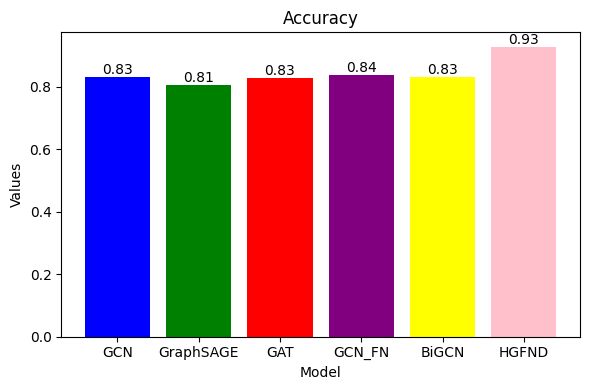

In [ ]:
import matplotlib.pyplot as plt

# Dữ liệu
categories = ['GCN', 'GraphSAGE','GAT', 'GCN_FN', 'BiGCN','HGFND']
values = [acc_GCN, acc_GraphSAGE, acc_GAT, acc_GCN_FN, acc_BiGCN, acc_HGFND]

plt.figure(figsize=(6, 4))
plt.bar(categories, values, color=['blue', 'green', 'red','purple', 'yellow','pink'])
plt.xlabel('Model')
plt.ylabel('Values')
plt.title('Accuracy')

# Hiển thị giá trị trên cột
for i in range(len(categories)):
     plt.text(i, values[i], '{:.2}'.format(values[i]), ha='center', va='bottom')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

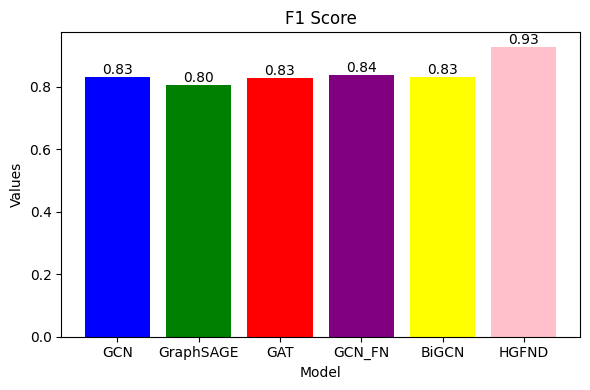

In [ ]:
# Dữ liệu
categories = ['GCN', 'GraphSAGE','GAT', 'GCN_FN', 'BiGCN', 'HGFND']
values = [f1_GCN, f1_GraphSAGE, f1_GAT, f1_GCN_FN, f1_BiGCN, f1_HGFND]

plt.figure(figsize=(6, 4))
plt.bar(categories, values, color=['blue', 'green', 'red','purple', 'yellow','pink'])
plt.xlabel('Model')
plt.ylabel('Values')
plt.title('F1 Score')

# Hiển thị giá trị trên cột
for i in range(len(categories)):
     plt.text(i, values[i], '{:.2f}'.format(values[i]), ha='center', va='bottom')

plt.tight_layout()
plt.show()